#YES


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from math import ceil
from scipy.ndimage import gaussian_filter

In [ ]:
# ==== ONE MIXED DATASET: correlated blocks + independent features (spatial maps) ====


rng = np.random.default_rng(123)

def _smooth(Z, sigma):
    return gaussian_filter(Z, sigma=sigma, mode="reflect") if sigma and sigma>0 else Z

def _standardize(A, eps=1e-12):
    A = A.astype(float)
    return (A - A.mean()) / (A.std() + eps)

def _flatten(Z):  # (ny,nx) -> (ny*nx,)
    return Z.reshape(-1)

def _proj_out(v, basis):
    """Remove components of v along all basis columns (least-squares)."""
    if basis.size == 0:
        return v
    # basis: shape (n, k); v: shape (n,)
    # Projection matrix: B(B^+ v), with B^+ = (B^T B)^{-1} B^T
    BtB = basis.T @ basis
    coef = np.linalg.pinv(BtB) @ (basis.T @ v)
    return v - basis @ coef

def make_spatial_mixed(
    ny=28, nx=28, d=7,
    groups=([[0,1,2],[3,4]]),      # two correlated blocks
    rhos=(0.85, 0.75),             # within-group rhos (match len(groups))
    independent_idxs=(5,6),        # these will be decorrelated from group fields
    spatial_sigma=3.0,
    target_kind="quad_sin",
    noise_sigma=0.25,
    seed=42
):
    rng = np.random.default_rng(seed)
    assert len(groups) == len(rhos), "rhos must match number of groups"
    assert max([i for g in groups for i in g] + list(independent_idxs)) < d, "index out of range"

    # 1) Build one smooth shared field per group
    ny, nx = int(ny), int(nx)
    group_shared = []
    for _ in groups:
        gfield = _standardize(_smooth(rng.normal(size=(ny,nx)), spatial_sigma))
        group_shared.append(gfield)

    # 2) Construct each feature
    X_maps = [None]*d
    for gid, g in enumerate(groups):
        a = np.sqrt(max(0.0, rhos[gid])); b = np.sqrt(max(0.0, 1.0 - rhos[gid]))
        G = group_shared[gid]
        for j in g:
            Ej = _standardize(_smooth(rng.normal(size=(ny,nx)), spatial_sigma))
            X_maps[j] = _standardize(a*G + b*Ej)

    # 3) Independent features: make sure they are spatially smooth BUT orthogonal
    #    to *all* group shared fields (to keep correlations ≈ 0)
    if len(independent_idxs) > 0:
        # Build basis from all group shared fields (flattened)
        basis = np.column_stack([_flatten(_standardize(gs)) for gs in group_shared]) if group_shared else np.empty((ny*nx, 0))
        for j in independent_idxs:
            raw = _flatten(_standardize(_smooth(rng.normal(size=(ny,nx)), spatial_sigma)))
            clean = _proj_out(raw, basis)          # remove shared components
            clean = (clean - clean.mean()) / (clean.std() + 1e-12)
            X_maps[j] = clean.reshape(ny, nx)

    # 4) Any remaining feature indices not in groups or independent: make plain smooth random
    covered = set(independent_idxs) | set([k for g in groups for k in g])
    for j in range(d):
        if X_maps[j] is None:
            X_maps[j] = _standardize(_smooth(rng.normal(size=(ny,nx)), spatial_sigma))

    X_stack = np.stack(X_maps, axis=2)  # (ny,nx,d)

    # 5) Ground-truth target (same forms as before)
    def _target(Xs, kind="quad_sin"):
        if kind == "linear":
            w = np.linspace(1.0, 0.2, Xs.shape[2])
            return np.tensordot(Xs, w, axes=([2],[0]))
        if kind == "quad_sin":
            X = Xs if Xs.shape[2] >= 3 else np.pad(Xs, ((0,0),(0,0),(0,3-Xs.shape[2])), mode='constant')
            return 1.5*(X[:,:,0]**2) + np.sin(X[:,:,1]) + 0.5*X[:,:,2]
        if kind == "interaction":
            X = Xs if Xs.shape[2] >= 4 else np.pad(Xs, ((0,0),(0,0),(0,4-Xs.shape[2])), mode='constant')
            return X[:,:,0]*X[:,:,1] + 0.7*X[:,:,2] - 0.5*X[:,:,3]
        if kind == "symbolic":
            X = Xs if Xs.shape[2] >= 3 else np.pad(Xs, ((0,0),(0,0),(0,3-Xs.shape[2])), mode='constant')
            return np.exp(-X[:,:,0]) * np.cos(X[:,:,1]) + 0.2*X[:,:,2]
        return Xs[:,:,0]

    f_map = _target(X_stack, target_kind)
    y_map = f_map + rng.normal(0, noise_sigma, size=(ny, nx))

    # 6) DataFrame (flatten) + coords
    cols = [f"x{i}" for i in range(d)]
    df = pd.DataFrame(
        np.column_stack([X_stack[:,:,i].ravel() for i in range(d)] + [y_map.ravel()]),
        columns=cols + ["y"]
    )
    rr, cc = np.indices((ny, nx)); df["row"] = rr.ravel(); df["col"] = cc.ravel()

    meta = dict(n=ny*nx, d=d, ny=ny, nx=nx, groups=groups, rhos=rhos,
                independent=list(independent_idxs), spatial_sigma=spatial_sigma,
                target_kind=target_kind)
    return df, meta, X_stack, y_map

def plot_maps(X_stack, y_map, title_prefix="MIXED • "):
    ny, nx, d = X_stack.shape
    k = d + 1
    ncols = 4
    nrows = int(ceil(k / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.8*nrows))
    axes = np.atleast_2d(axes).ravel()
    for j in range(d):
        im = axes[j].imshow(X_stack[:,:,j], origin="upper", cmap="viridis")
        axes[j].set_title(f"{title_prefix}x{j}")
        axes[j].set_xticks([]); axes[j].set_yticks([])
        plt.colorbar(im, ax=axes[j], fraction=0.046, pad=0.04)
    im = axes[d].imshow(y_map, origin="upper", cmap="viridis")
    axes[d].set_title(f"{title_prefix}y"); axes[d].set_xticks([]); axes[d].set_yticks([])
    plt.colorbar(im, ax=axes[d], fraction=0.046, pad=0.04)
    for ax in axes[k:]: ax.axis("off")
    plt.tight_layout(); plt.show()

def correlation_heatmap(df, title="Feature×Feature correlation"):
    xcols = [c for c in df.columns if c.startswith("x")]
    C = df[xcols].corr().to_numpy()
    fig, ax = plt.subplots(figsize=(5.4,4.8))
    im = ax.imshow(C, vmin=-1, vmax=1, cmap="coolwarm")
    ax.set_xticks(range(len(xcols))); ax.set_yticks(range(len(xcols)))
    ax.set_xticklabels(xcols, rotation=45, ha="right"); ax.set_yticklabels(xcols)
    ax.set_title(title); plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()




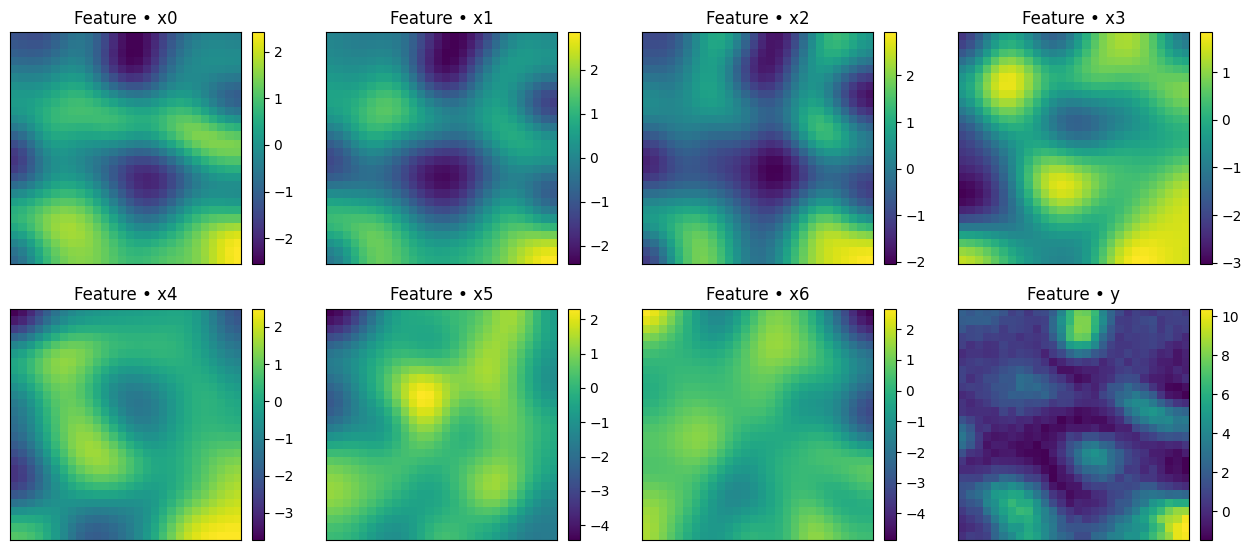

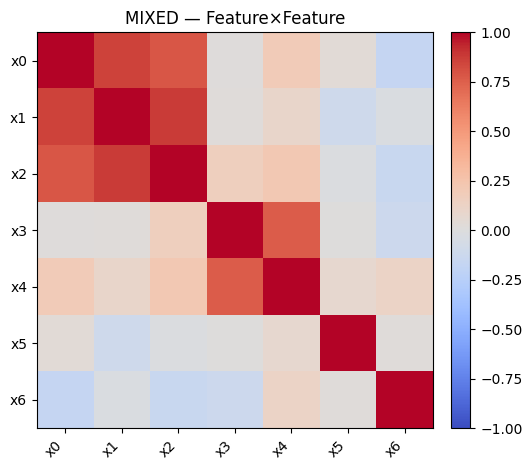

In [ ]:
# ---- Build & show the mixed set ----
df_mix, meta_mix, X_mix, y_mix = make_spatial_mixed(
    ny=28, nx=28, d=7,
    groups=[[0,1,2],[3,4]],     # correlated blocks
    rhos=(0.85, 0.75),
    independent_idxs=(5,6),     # truly independent (decorrelated from group fields)
    spatial_sigma=3.0,
    target_kind="quad_sin",
    noise_sigma=0.25,
    seed=7
)

plot_maps(X_mix, y_mix, title_prefix="Feature • ")
correlation_heatmap(df_mix, title="MIXED — Feature×Feature")

##MODELS

In [ ]:
!pip install -q gplearn

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Linear / kernel / neighbors
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Trees / ensembles
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

# MLP
from sklearn.neural_network import MLPRegressor

# Optional: XGBoost if available
try:
    from xgboost import XGBRegressor
    _HAS_XGB = True
except Exception:
    _HAS_XGB = False

try:
    from gplearn.genetic import SymbolicRegressor
    _HAS_GPLEARN = True
except Exception:
    _HAS_GPLEARN = False

RNG = 7

In [ ]:
def build_model_zoo(random_state=RNG):
    """Return dict: name -> (estimator_or_pipeline, param_dist)."""
    zoo = {}

    # --- Linear family ---
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
    from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
    from sklearn.svm import SVR
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
    from sklearn.neural_network import MLPRegressor
    import numpy as np

    zoo["Linear"] = (
        Pipeline([("scaler", StandardScaler()), ("m", LinearRegression())]),
        {"scaler": [StandardScaler(), RobustScaler(), MinMaxScaler()]}
    )
    zoo["Ridge"] = (
        Pipeline([("scaler", StandardScaler()), ("m", Ridge(random_state=random_state))]),
        {"scaler":[StandardScaler(), RobustScaler(), MinMaxScaler()],
         "m__alpha": np.logspace(-4, 3, 50)}
    )
    zoo["Lasso"] = (
        Pipeline([("scaler", StandardScaler()), ("m", Lasso(random_state=random_state, max_iter=10000))]),
        {"scaler":[StandardScaler(), RobustScaler(), MinMaxScaler()],
         "m__alpha": np.logspace(-4, 1, 50)}
    )
    zoo["ElasticNet"] = (
        Pipeline([("scaler", StandardScaler()), ("m", ElasticNet(random_state=random_state, max_iter=10000))]),
        {"scaler":[StandardScaler(), RobustScaler(), MinMaxScaler()],
         "m__alpha": np.logspace(-4, 1, 50),
         "m__l1_ratio": np.linspace(0.05, 0.95, 19)}
    )

    # --- Kernel / neighbors ---
    zoo["SVR-RBF"] = (
        Pipeline([("scaler", StandardScaler()), ("m", SVR(kernel="rbf"))]),
        {"scaler":[StandardScaler(), RobustScaler(), MinMaxScaler()],
         "m__C":     np.logspace(-2, 3, 30),
         "m__gamma": np.logspace(-4, 1, 30),
         "m__epsilon": np.logspace(-3, 0, 15)}
    )
    zoo["KNN"] = (
        Pipeline([("scaler", StandardScaler()), ("m", KNeighborsRegressor())]),
        {"scaler":[StandardScaler(), RobustScaler(), MinMaxScaler()],
         "m__n_neighbors": list(range(3, 41, 2)),
         "m__weights": ["uniform", "distance"],
         "m__p": [1, 2]}
    )

    # --- Trees / ensembles ---
    zoo["RF"] = (
        RandomForestRegressor(n_estimators=500, random_state=random_state, n_jobs=-1),
        {"max_depth":[None]+list(range(3,31,3)),
         "min_samples_split":[2,5,10],
         "min_samples_leaf":[1,2,4],
         "max_features":["sqrt","log2",None]}
    )
    zoo["ExtraTrees"] = (
        ExtraTreesRegressor(n_estimators=600, random_state=random_state, n_jobs=-1),
        {"max_depth":[None]+list(range(3,31,3)),
         "min_samples_split":[2,5,10],
         "min_samples_leaf":[1,2,4],
         "max_features":["sqrt","log2",None]}
    )
    zoo["GBDT"] = (
        GradientBoostingRegressor(random_state=random_state),
        {"n_estimators":[200,300,500,800],
         "learning_rate": np.logspace(-3, -0.3, 10),
         "max_depth":[2,3,4,5],
         "subsample":[0.6,0.8,1.0],
         "min_samples_leaf":[1,2,4]}
    )
    zoo["HGBDT"] = (
        HistGradientBoostingRegressor(random_state=random_state),
        {"learning_rate": np.logspace(-3, -0.3, 10),
         "max_depth":[None,4,6,8,12],
         "l2_regularization": np.logspace(-6, 1, 10)}
    )

    # --- MLP ---
    zoo["MLP"] = (
        Pipeline([("scaler", StandardScaler()),
                  ("m", MLPRegressor(max_iter=800, early_stopping=True, random_state=random_state))]),
        {"scaler":[StandardScaler(), RobustScaler()],
         "m__hidden_layer_sizes":[(64,64),(128,64),(128,128),(256,128),(64,64,32)],
         "m__activation":["relu","tanh"],
         "m__alpha": np.logspace(-6, -2, 10),
         "m__learning_rate_init": np.logspace(-4, -2, 6),
         "m__batch_size":[32,64,128]}
    )

    # --- Optional XGBoost ---
    try:
        from xgboost import XGBRegressor
        zoo["XGB"] = (
            XGBRegressor(n_estimators=1200, random_state=random_state, n_jobs=-1,
                         tree_method="hist", reg_lambda=1.0, reg_alpha=0.0),
            {"max_depth":[3,4,5,6,8],
             "learning_rate": np.logspace(-3, -0.2, 12),
             "subsample":[0.6,0.8,1.0],
             "colsample_bytree":[0.6,0.8,1.0],
             "min_child_weight":[1,5,10],
             "gamma":[0.0,0.1,0.2]}
        )
    except Exception:
        pass

    # --- Symbolic Regression (gplearn) ---
    if _HAS_GPLEARN:
        # No scaler; it works on raw features. Ensure float64 upstream.
        zoo["SymReg"] = (
            SymbolicRegressor(
                population_size=1200,
                generations=20,
                tournament_size=20,
                stopping_criteria=0.0,
                function_set=("add","sub","mul","div","sin","cos","sqrt","log"),
                metric="mean absolute error",
                p_crossover=0.6,
                p_subtree_mutation=0.2,
                p_hoist_mutation=0.05,
                p_point_mutation=0.15,
                parsimony_coefficient=1e-4,
                max_samples=0.9,
                n_jobs=-1,
                verbose=0,
                random_state=random_state
            ),
            {
                "population_size": [600, 900, 1200, 1500],
                "generations": [15, 20, 30],
                "tournament_size": [10, 20, 30],
                "p_crossover": np.linspace(0.5, 0.9, 5),
                "p_subtree_mutation": np.linspace(0.1, 0.4, 4),
                "p_hoist_mutation": [0.02, 0.05, 0.1],
                "p_point_mutation": np.linspace(0.05, 0.25, 5),
                "parsimony_coefficient": np.logspace(-6, -2, 9),
                "function_set": [
                    ("add","sub","mul","div","sin","cos","sqrt","log"),
                    ("add","sub","mul","div","sin","cos","sqrt"),
                    ("add","sub","mul","div","sqrt","log")
                ],
            }
        )
    return zoo

def run_model_search(df, *, feature_prefix="x", ycol="y",
                     test_size=0.2, random_state=RNG,
                     cv_splits=5, n_iter=40, per_model_n_iter=None,
                     n_jobs=-1, verbose=1):
    """
    per_model_n_iter: optional dict like {"SymReg": 15, "MLP": 50} to override n_iter per model.
    """
    X, y, xcols = make_Xy(df, feature_prefix, ycol)
    # gplearn prefers float64
    X = X.astype(np.float64, copy=False)
    y = y.astype(np.float64, copy=False)

    from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=random_state)

    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    zoo = build_model_zoo(random_state=random_state)

    results, best_models = [], {}

    for name, (estimator, param_dist) in zoo.items():
        this_iter = per_model_n_iter.get(name, n_iter) if per_model_n_iter else n_iter

        rs = RandomizedSearchCV(
            estimator, param_distributions=param_dist, n_iter=this_iter, cv=cv,
            scoring="r2", n_jobs=n_jobs, random_state=random_state, verbose=verbose, refit=True
        )
        rs.fit(Xtr, ytr)

        yhat = rs.best_estimator_.predict(Xte)
        s = _scores(yte, yhat)
        s.update(dict(model=name, best_params=rs.best_params_))
        results.append(s)
        best_models[name] = rs.best_estimator_

        print(f"\n{name}: best CV R2={rs.best_score_:.3f} | TEST {{'R2':{s['R2']:.3f}, 'RMSE':{s['RMSE']:.3f}, 'MAE':{s['MAE']:.3f}}}")

    leaderboard = pd.DataFrame(results).sort_values("R2", ascending=False).reset_index(drop=True)
    return leaderboard, best_models, (Xtr, Xte, ytr, yte), xcols

def _scores(y_true, y_pred):
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
    return dict(
        R2=float(r2_score(y_true, y_pred)),
        RMSE=float(np.sqrt(mean_squared_error(y_true, y_pred))),
        MAE=float(mean_absolute_error(y_true, y_pred)),
    )

def plot_best(model, Xte, yte, title="Best model: Predictions vs Truth"):
    yhat = model.predict(Xte)
    s = _scores(yte, yhat)
    plt.figure(figsize=(5.4, 4.6))
    plt.scatter(yte, yhat, s=14, alpha=0.8)
    lims = [min(yte.min(), yhat.min()), max(yte.max(), yhat.max())]
    plt.plot(lims, lims, lw=1)
    plt.xlabel("True y"); plt.ylabel("Predicted y")
    plt.title(f"{title}\nR²={s['R2']:.3f}  RMSE={s['RMSE']:.3f}  MAE={s['MAE']:.3f}")
    plt.tight_layout(); plt.show()

def make_Xy(df, feature_prefix="x", ycol="y"):
    """
    Split a DataFrame into (X, y, feature_names).
    - X: numpy array of features
    - y: numpy array of target
    - feature_names: list of feature column names
    """
    xcols = [c for c in df.columns if c.startswith(feature_prefix)]
    X = df[xcols].to_numpy(dtype=float)
    y = df[ycol].to_numpy(dtype=float)
    return X, y, xcols


In [ ]:
def summarize_winners(leaderboard, best_models):
    rows = []
    for m in leaderboard["model"]:
        est = best_models[m]
        # Try to get params from pipeline step "m" if present
        if hasattr(est, "get_params"):
            params = est.get_params()
        else:
            params = {}
        rows.append({"model": m, "best_estimator_type": type(est).__name__, "n_params": len(params)})
    return pd.DataFrame(rows)

def show_best_params(best_models, model_name):
    print(f"\n=== {model_name}: best estimator params ===")
    est = best_models[model_name]
    try:
        # If it’s a Pipeline, show the model step neatly
        from sklearn.pipeline import Pipeline
        if isinstance(est, Pipeline):
            print("Scaler:", est.named_steps.get("scaler", None))
            print("Model :", est.named_steps["m"].__class__.__name__)
            pprint(est.named_steps["m"].get_params())
        else:
            print("Model :", est.__class__.__name__)
            pprint(est.get_params())
    except Exception as e:
        print("Could not pretty-print params:", e)

def plot_preds_for_all(best_models, splits, max_cols=4):
    Xtr, Xte, ytr, yte = splits
    names = list(best_models.keys())
    n = len(names)
    ncols = min(max_cols, n)
    nrows = (n + ncols - 1)//ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.2*ncols, 3.8*nrows))
    axes = axes.ravel()
    for ax, name in zip(axes, names):
        est = best_models[name]
        yhat = est.predict(Xte)
        ax.scatter(yte, yhat, s=10, alpha=0.8)
        lims = [min(yte.min(), yhat.min()), max(yte.max(), yhat.max())]
        ax.plot(lims, lims, lw=1)
        ax.set_title(name, fontsize=10)
        ax.set_xlabel("True"); ax.set_ylabel("Pred")
    for ax in axes[len(names):]: ax.axis("off")
    plt.tight_layout(); plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=35. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Linear: best CV R2=0.280 | TEST {'R2':0.338, 'RMSE':1.799, 'MAE':1.390}

Ridge: best CV R2=0.280 | TEST {'R2':0.340, 'RMSE':1.797, 'MAE':1.386}

Lasso: best CV R2=0.280 | TEST {'R2':0.339, 'RMSE':1.797, 'MAE':1.387}

ElasticNet: best CV R2=0.280 | TEST {'R2':0.340, 'RMSE':1.796, 'MAE':1.384}

SVR-RBF: best CV R2=0.984 | TEST {'R2':0.988, 'RMSE':0.241, 'MAE':0.188}

KNN: best CV R2=0.956 | TEST {'R2':0.966, 'RMSE':0.406, 'MAE':0.329}

RF: best CV R2=0.973 | TEST {'R2':0.983, 'RMSE':0.292, 'MAE':0.237}

ExtraTrees: best CV R2=0.981 | TEST {'R2':0.987, 'RMSE':0.252, 'MAE':0.207}

GBDT: best CV R2=0.980 | TEST {'R2':0.985, 'RMSE':0.269, 'MAE':0.216}

HGBDT: best CV R2=0.959 | TEST {'R2':0.962, 'RMSE':0.432, 'MAE':0.296}

MLP: best CV R2=0.981 | TEST {'R2':0.982, 'RMSE':0.294, 'MAE':0.221}

XGB: best CV R2=0.979 | TEST {'R2':0.985, 'RMSE':0.271, 'MAE':0.214}


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
55 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/gplearn/genetic.py", line 374, in fit
    raise ValueError('The sum of p_crossover, p_subtree_mutation, '
ValueError: The sum of p_crossover, p_subtree_mutation, p_hoist_mutation and p_point_mutation should total to 1.0 or less.

  warnings.warn(some_fits_failed_messa


SymReg: best CV R2=0.969 | TEST {'R2':0.971, 'RMSE':0.377, 'MAE':0.300}

=== Leaderboard (TEST set) ===


,model,R2,RMSE,MAE,best_params
0,SVR-RBF,0.988114,0.241056,0.187938,"{'scaler': RobustScaler(), 'm__gamma': 0.01172..."
1,ExtraTrees,0.986999,0.252108,0.207009,"{'min_samples_split': 5, 'min_samples_leaf': 2..."
2,GBDT,0.985156,0.269389,0.216348,"{'subsample': 0.6, 'n_estimators': 800, 'min_s..."
3,XGB,0.984936,0.271373,0.214091,"{'subsample': 0.6, 'min_child_weight': 1, 'max..."
4,RF,0.982571,0.291903,0.236585,"{'min_samples_split': 2, 'min_samples_leaf': 1..."
5,MLP,0.982284,0.294300,0.221059,"{'scaler': RobustScaler(), 'm__learning_rate_i..."
6,SymReg,0.970883,0.377291,0.300115,"{'tournament_size': 10, 'population_size': 150..."
7,KNN,0.966277,0.406040,0.328729,"{'scaler': MinMaxScaler(), 'm__weights': 'dist..."
8,HGBDT,0.961885,0.431670,0.296089,"{'max_depth': 8, 'learning_rate': 0.1258925411..."
9,ElasticNet,0.340069,1.796192,1.383636,"{'scaler': MinMaxScaler(), 'm__l1_ratio': 0.75..."



Best model: SVR-RBF


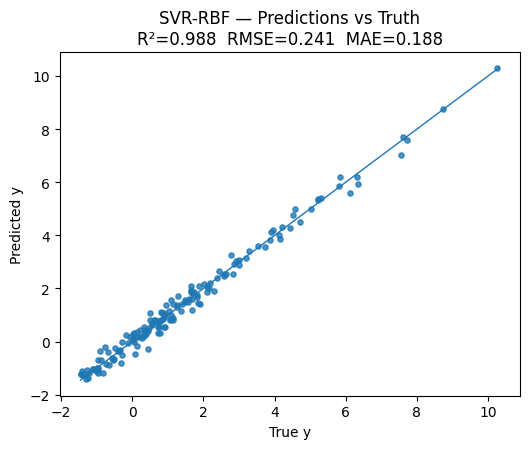

In [ ]:
leaderboard, best_models, splits, xcols = run_model_search(
    df_mix,
    test_size=0.2,
    cv_splits=5,
    n_iter=35,                       # default for most models
    per_model_n_iter={"SymReg": 15}, # smaller budget for gplearn
    n_jobs=-1,
    verbose=0
)

print("\n=== Leaderboard (TEST set) ===")
display(leaderboard[["model","R2","RMSE","MAE","best_params"]])

best_name = leaderboard.iloc[0]["model"]
print(f"\nBest model: {best_name}")
plot_best(best_models[best_name], splits[1], splits[3], title=f"{best_name} — Predictions vs Truth")


,model,best_estimator_type,n_params
0,SVR-RBF,Pipeline,22
1,ExtraTrees,ExtraTreesRegressor,18
2,GBDT,GradientBoostingRegressor,21
3,XGB,XGBRegressor,40
4,RF,RandomForestRegressor,18
5,MLP,Pipeline,34
6,SymReg,SymbolicRegressor,22
7,KNN,Pipeline,17
8,HGBDT,HistGradientBoostingRegressor,21
9,ElasticNet,Pipeline,20



=== SVR-RBF: best estimator params ===
Scaler: RobustScaler()
Model : SVR
Could not pretty-print params: name 'pprint' is not defined

=== ExtraTrees: best estimator params ===
Model : ExtraTreesRegressor
Could not pretty-print params: name 'pprint' is not defined

=== GBDT: best estimator params ===
Model : GradientBoostingRegressor
Could not pretty-print params: name 'pprint' is not defined

=== XGB: best estimator params ===
Model : XGBRegressor
Could not pretty-print params: name 'pprint' is not defined

=== RF: best estimator params ===
Model : RandomForestRegressor
Could not pretty-print params: name 'pprint' is not defined

=== MLP: best estimator params ===
Scaler: RobustScaler()
Model : MLPRegressor
Could not pretty-print params: name 'pprint' is not defined

=== SymReg: best estimator params ===
Model : SymbolicRegressor
Could not pretty-print params: name 'pprint' is not defined

=== KNN: best estimator params ===
Scaler: MinMaxScaler()
Model : KNeighborsRegressor
Could not

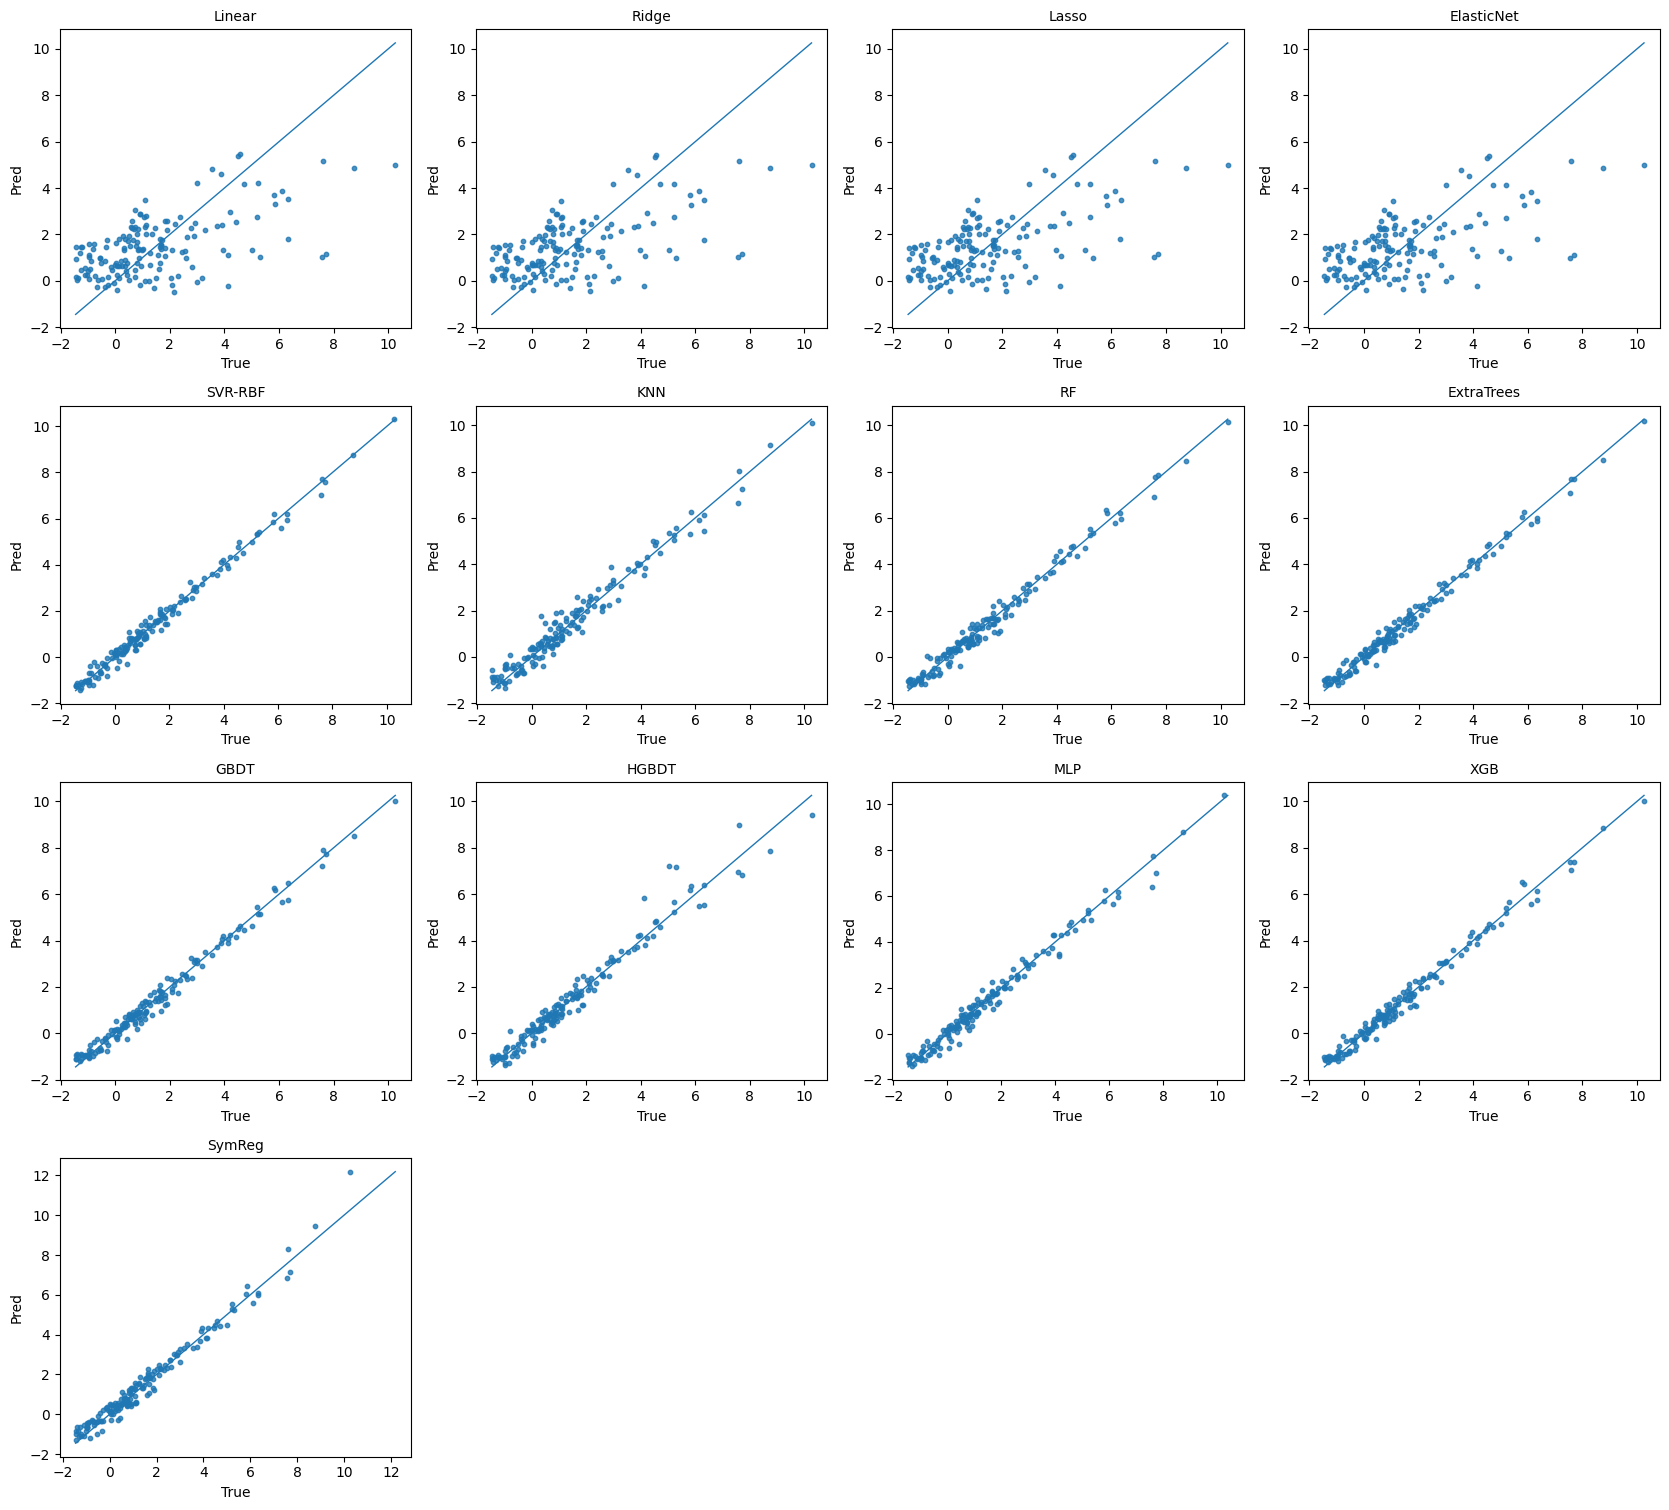

In [ ]:
display(summarize_winners(leaderboard, best_models))
for m in leaderboard["model"]:
    show_best_params(best_models, m)

plot_preds_for_all(best_models, splits)

##SHAP

In [ ]:
# ==== SHAP for best architecture of each model ====
import numpy as np, shap, matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# --- Helpers to unwrap pipelines and wrap predict so SHAP sees RAW X ---
def _unwrap_estimator(est):
    """Return (model, scaler or None). Works for plain estimators or Pipelines with ('scaler','m')."""
    if isinstance(est, Pipeline):
        scaler = est.named_steps.get("scaler", None)
        model  = est.named_steps.get("m", None)
        # allow pipelines without 'm' key (rare)
        if model is None:
            # last step as model
            last_key = list(est.named_steps.keys())[-1]
            model = est.named_steps[last_key]
            # assume first step is scaler if it looks like one
            first_key = list(est.named_steps.keys())[0]
            if "scale" in first_key:
                scaler = est.named_steps[first_key]
        return model, scaler
    return est, None

def _predict_fn(model, scaler=None):
    """Predict on RAW X; if scaler is present, apply it inside the lambda."""
    if scaler is None:
        return model.predict
    return lambda XR: model.predict(scaler.transform(XR))

# --- Correlation-based feature clustering for clustered bars ---
def _build_feature_clustering(X_train, y_train=None):
    # SHAP supports hclust(X[, y]); fallback to correlation-only if needed
    try:
        return shap.utils.hclust(X_train, y_train)
    except TypeError:
        return shap.utils.hclust(X_train, metric="correlation")

def _to_explanation(shap_values, X_for_plot, feature_names):
    sv = shap_values[0] if isinstance(shap_values, list) else shap_values
    sv = np.asarray(sv)                               # (n_samples, n_features)
    base = np.zeros(sv.shape[0], dtype=float)         # bar() ignores base_values
    return shap.Explanation(values=sv, base_values=base, data=X_for_plot,
                            feature_names=feature_names)

def _clustered_bar(explanation, linkage, title, cutoff=None):
    """Try SHAP's clustered bar; robust manual fallback that groups mean|SHAP| by clusters."""
    drew = False
    try:
        fig, ax = plt.subplots(figsize=(6,4))
        if cutoff is None:
            shap.plots.bar(explanation, max_display=12, clustering=linkage)
        else:
            shap.plots.bar(explanation, max_display=12, clustering=linkage, clustering_cutoff=float(cutoff))
        drew = (len(ax.patches) > 0) or (len(ax.containers) > 0)
        if drew:
            ax.set_title(title); plt.tight_layout(); plt.show()
        else:
            plt.close(fig)
    except Exception:
        try: plt.close(fig)
        except Exception: pass
        drew = False

    if not drew:
        # manual fallback
        from scipy.cluster.hierarchy import fcluster, leaves_list
        sv = explanation.values
        mean_abs = np.mean(np.abs(sv), axis=0)
        if cutoff is None:
            order = leaves_list(linkage)
            vals  = mean_abs[order]
            labels= [explanation.feature_names[i] for i in order]
        else:
            clusters = fcluster(linkage, t=float(cutoff), criterion="distance")
            groups = {}
            for j, cid in enumerate(clusters):
                groups.setdefault(int(cid), []).append(j)
            vals, labels = [], []
            for cid, idxs in groups.items():
                vals.append(float(mean_abs[idxs].sum()))
                labels.append(explanation.feature_names[idxs[0]] if len(idxs)==1
                              else explanation.feature_names[idxs[0]]+f" (+{len(idxs)-1})")
            order = np.argsort(vals)[::-1]
            vals  = np.array(vals)[order]
            labels= [labels[i] for i in order]

        plt.figure(figsize=(6, max(3, 0.35*len(labels))))
        y = np.arange(len(labels))
        plt.barh(y, vals)
        plt.yticks(y, labels)
        plt.gca().invert_yaxis()
        plt.xlabel("mean |SHAP| (grouped)")
        plt.title(title)
        plt.tight_layout(); plt.show()

def shap_best_for_all(best_models, splits, xcols, *, nsamples_kernel=100, do_clustered_bar=True):
    """
    For each best model:
      - choose the right SHAP explainer
      - draw summary plot (vs RAW X)
      - optionally draw clustered bar (correlation-aware grouping)
    """
    Xtr, Xte, ytr, yte = splits

    # Build one linkage from the training data (RAW X) for consistent grouping
    linkage = _build_feature_clustering(Xtr, ytr) if do_clustered_bar else None

    for name, est in best_models.items():
        model, scaler = _unwrap_estimator(est)
        cls = model.__class__.__name__.lower()

        print(f"\n=== {name} — {model.__class__.__name__} ===")

        # Choose explainer
        try:
            if any(k in cls for k in ["linearregression","ridge","lasso","elasticnet"]):
                # Work in scaled space for the model, plot vs RAW X
                Xtr_s = scaler.fit_transform(Xtr) if scaler is not None else Xtr
                Xte_s = scaler.transform(Xte)     if scaler is not None else Xte
                explainer = shap.LinearExplainer(model, Xtr_s, feature_names=xcols)
                sv = explainer.shap_values(Xte_s)
                shap.summary_plot(sv, Xte, feature_names=xcols, show=False)
                plt.title(f"{name} — SHAP summary (LinearExplainer)"); plt.tight_layout(); plt.show()

            elif any(k in cls for k in ["randomforest","extratrees","gradientboosting","histgradientboosting","xgbregressor"]):
                # Trees: TreeExplainer, interventional (independent) by default
                fe_pert = "interventional"
                explainer = shap.TreeExplainer(model, feature_names=xcols, feature_perturbation=fe_pert, model_output="raw")
                sv = explainer.shap_values(Xte)
                shap.summary_plot(sv, Xte, feature_names=xcols, show=False)
                plt.title(f"{name} — SHAP summary (TreeExplainer)"); plt.tight_layout(); plt.show()

            else:
                # SVR, KNN, MLP, SymReg → KernelExplainer (black-box, independent assumption)
                f = _predict_fn(model, scaler=scaler)
                bg = Xtr if len(Xtr) <= 200 else Xtr[np.random.choice(len(Xtr), 200, replace=False)]
                explainer = shap.KernelExplainer(f, bg)
                sv = explainer.shap_values(Xte, nsamples=nsamples_kernel)
                shap.summary_plot(sv, Xte, feature_names=xcols, show=False)
                plt.title(f"{name} — SHAP summary (KernelExplainer)"); plt.tight_layout(); plt.show()

            # Clustered bar (optional)
            if do_clustered_bar:
                ex_bar = _to_explanation(sv, Xte, xcols)
                _clustered_bar(ex_bar, linkage, title=f"{name} — Clustered SHAP bar", cutoff=1.0)

        except Exception as e:
            print(f"SHAP failed for {name}: {e}")





=== Linear — LinearRegression ===


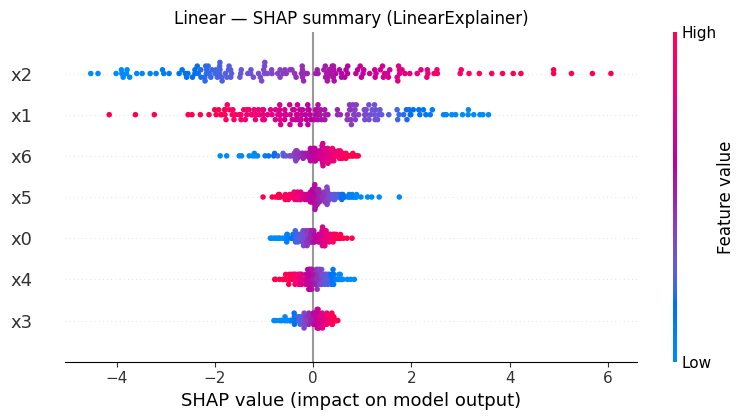

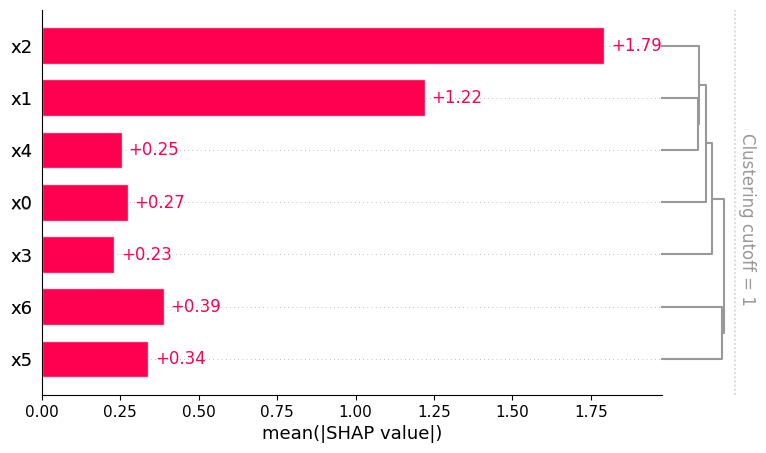

<Figure size 640x480 with 0 Axes>


=== Ridge — Ridge ===


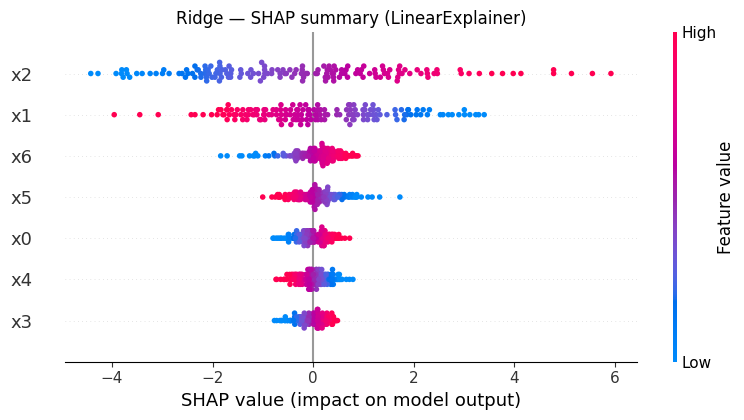

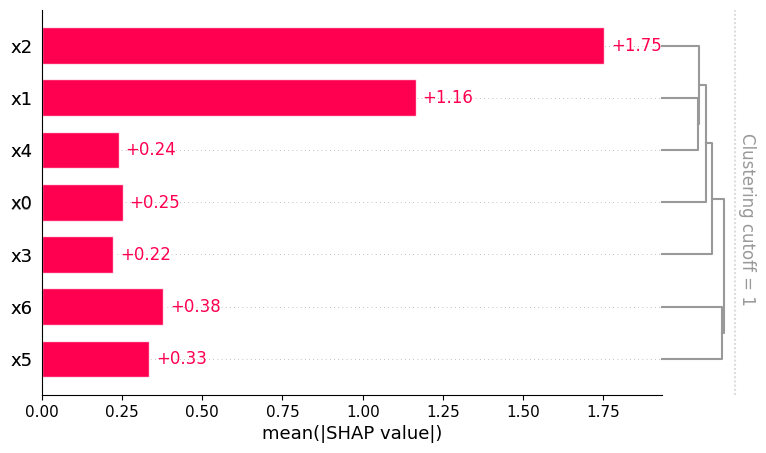

<Figure size 640x480 with 0 Axes>


=== Lasso — Lasso ===


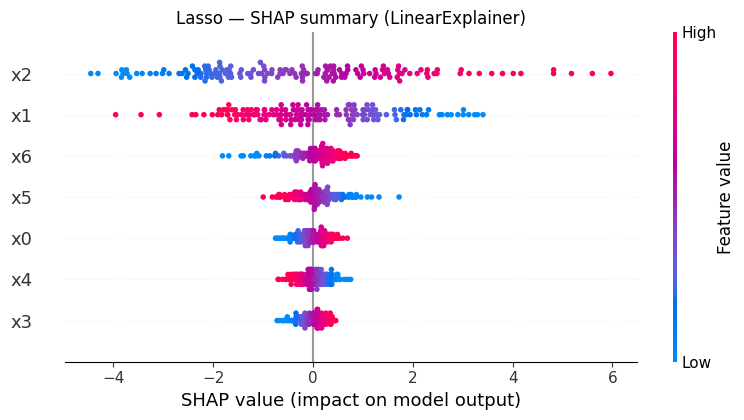

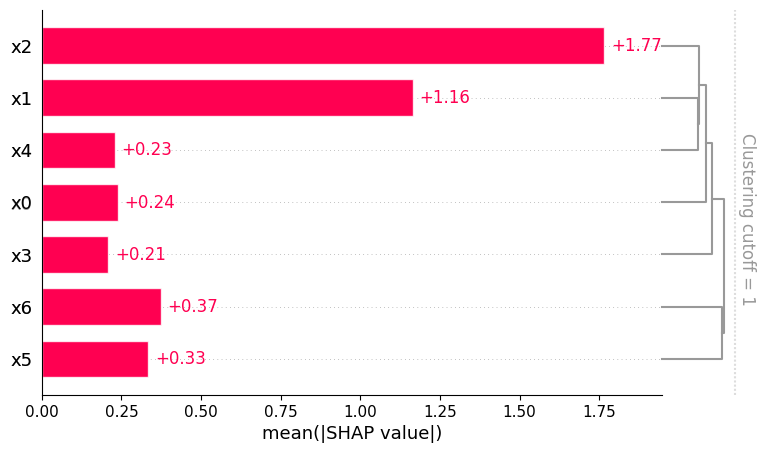

<Figure size 640x480 with 0 Axes>


=== ElasticNet — ElasticNet ===


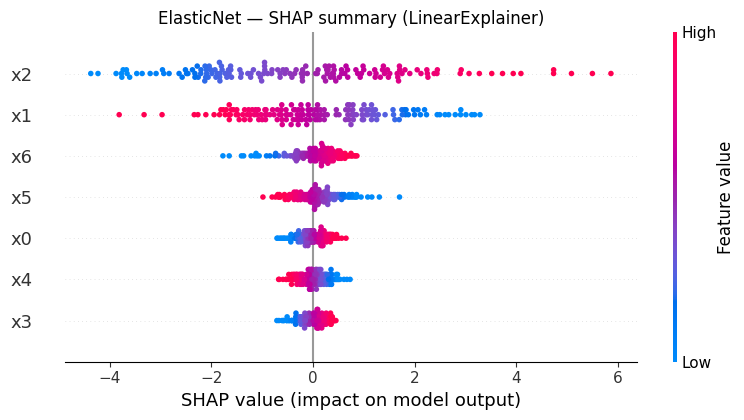

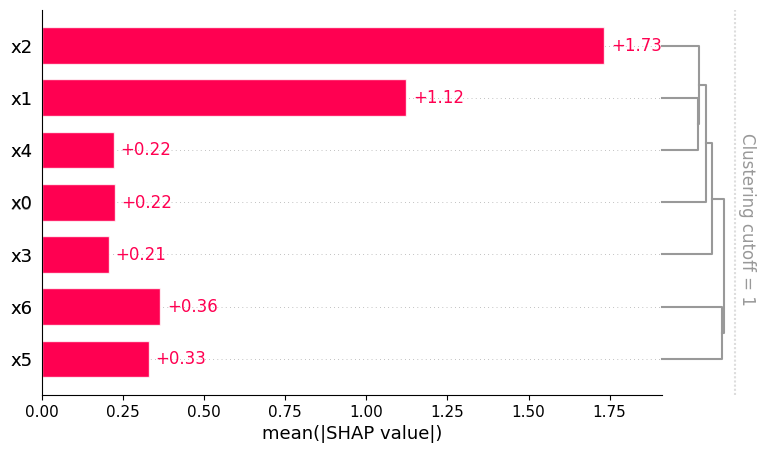

<Figure size 640x480 with 0 Axes>


=== SVR-RBF — SVR ===


  0%|          | 0/157 [00:00<?, ?it/s]

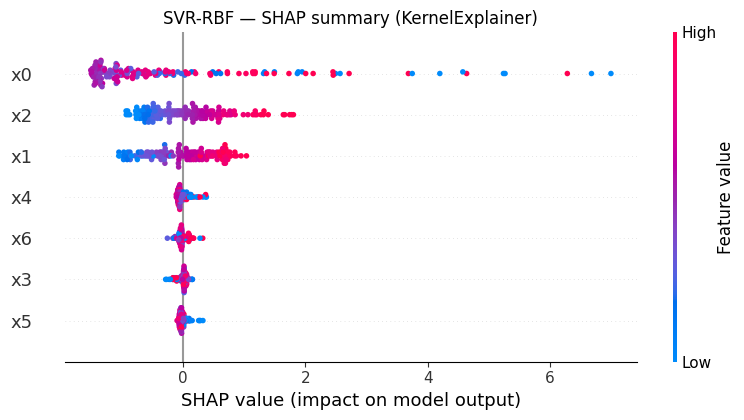

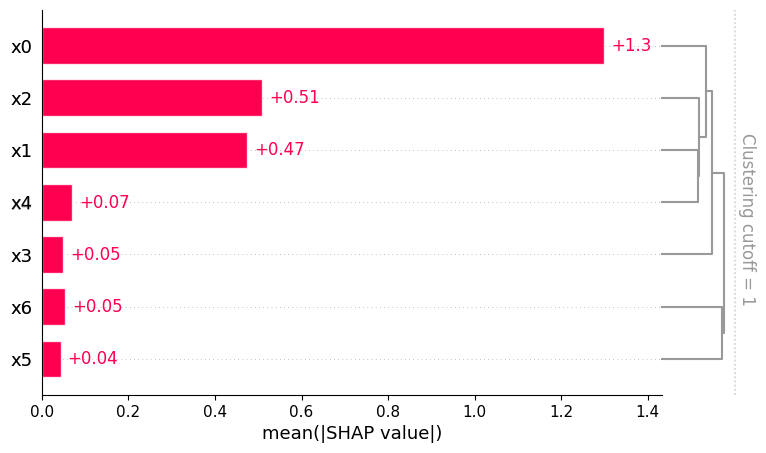

<Figure size 640x480 with 0 Axes>


=== KNN — KNeighborsRegressor ===


  0%|          | 0/157 [00:00<?, ?it/s]

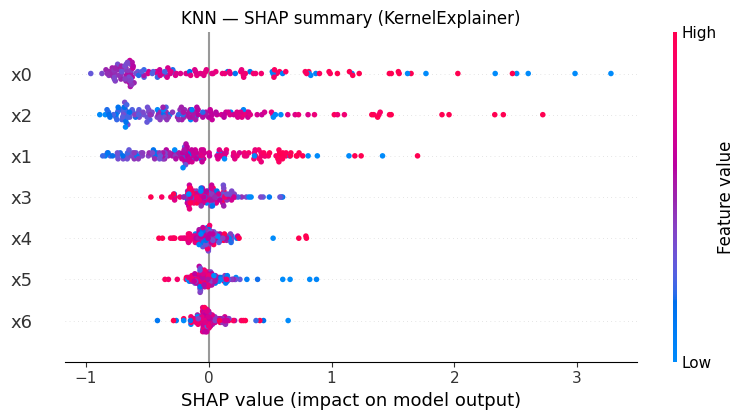

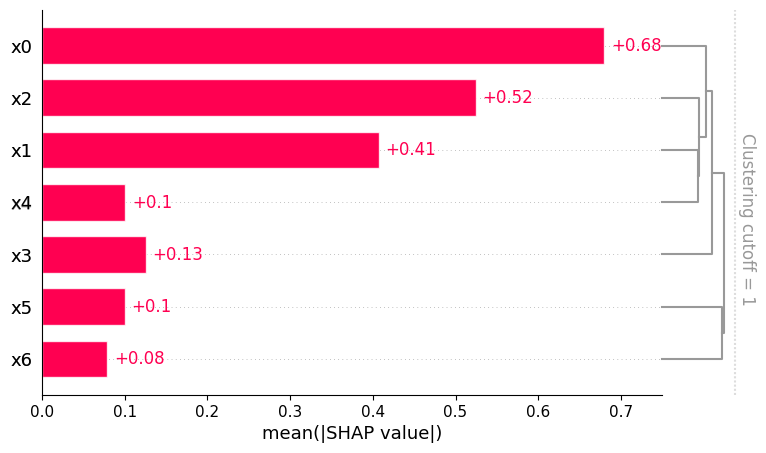

<Figure size 640x480 with 0 Axes>


=== RF — RandomForestRegressor ===


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


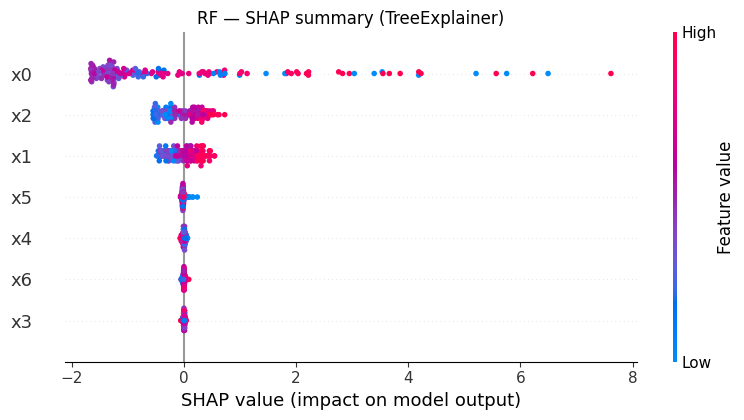

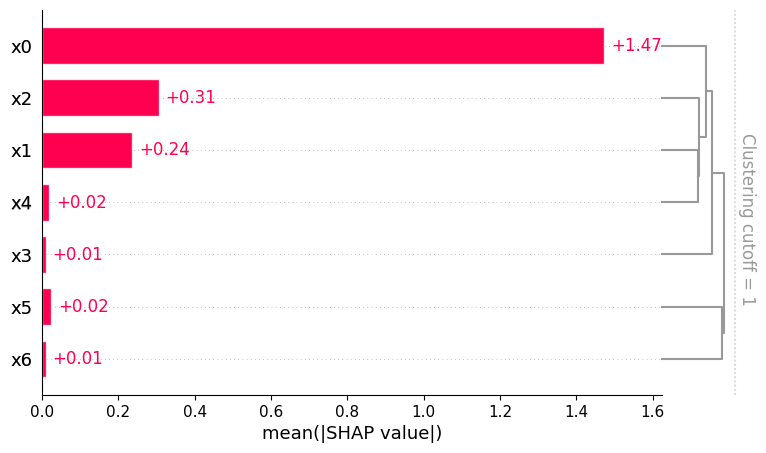

<Figure size 640x480 with 0 Axes>


=== ExtraTrees — ExtraTreesRegressor ===


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


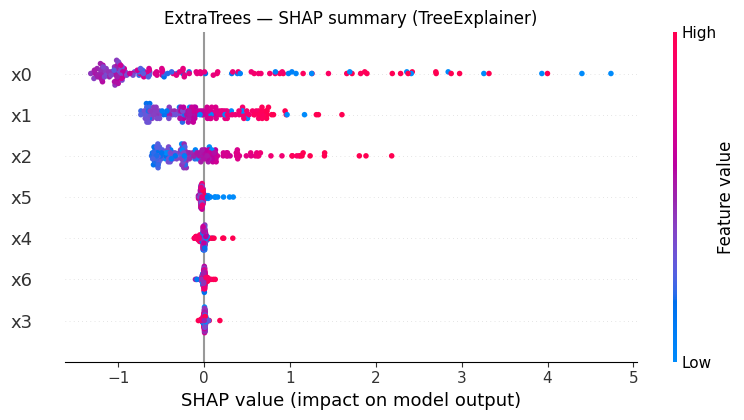

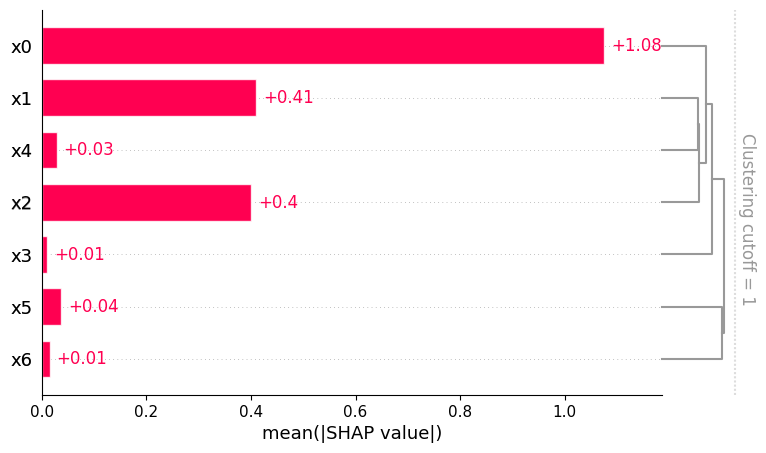

<Figure size 640x480 with 0 Axes>


=== GBDT — GradientBoostingRegressor ===


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


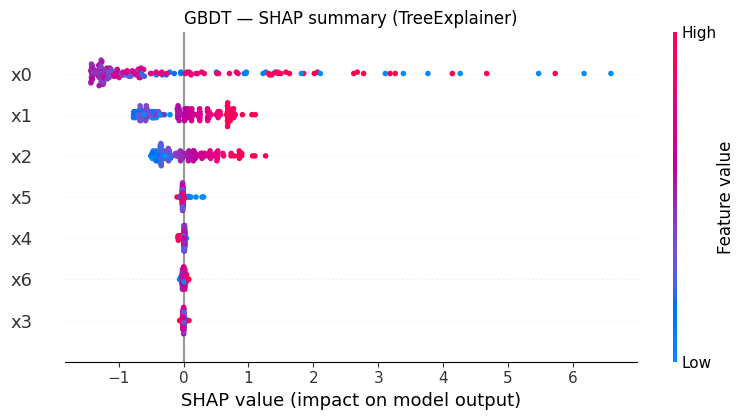

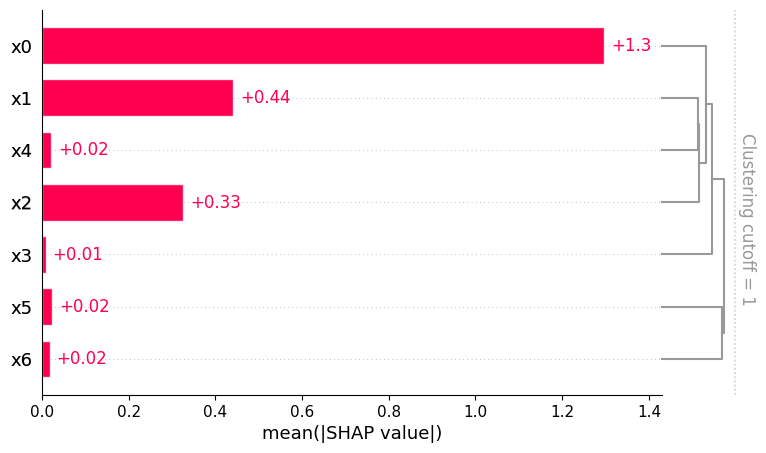

<Figure size 640x480 with 0 Axes>


=== HGBDT — HistGradientBoostingRegressor ===


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


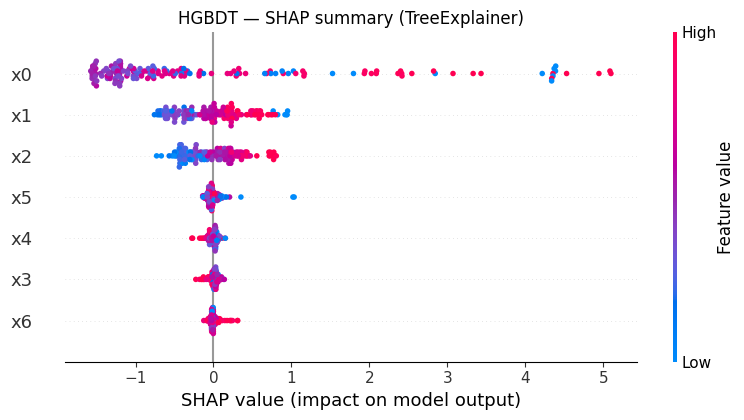

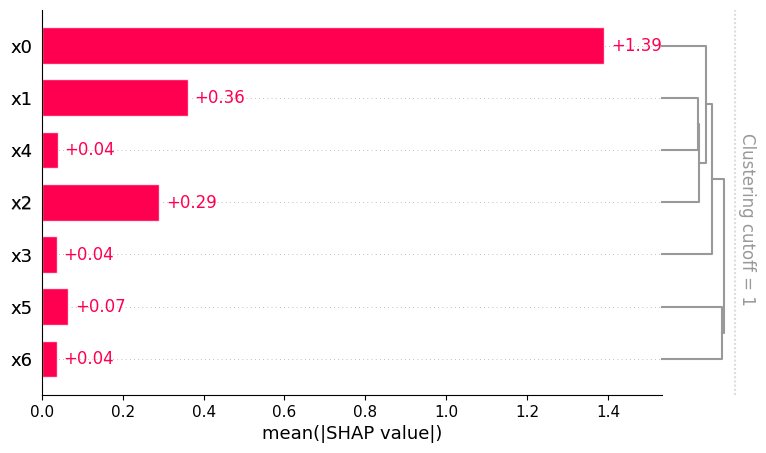

<Figure size 640x480 with 0 Axes>


=== MLP — MLPRegressor ===


  0%|          | 0/157 [00:00<?, ?it/s]

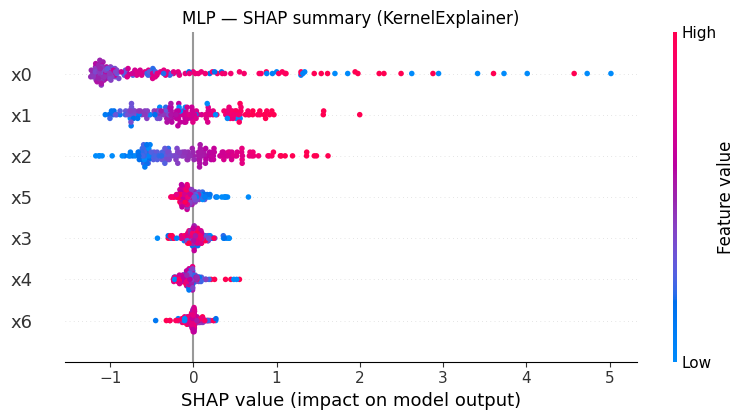

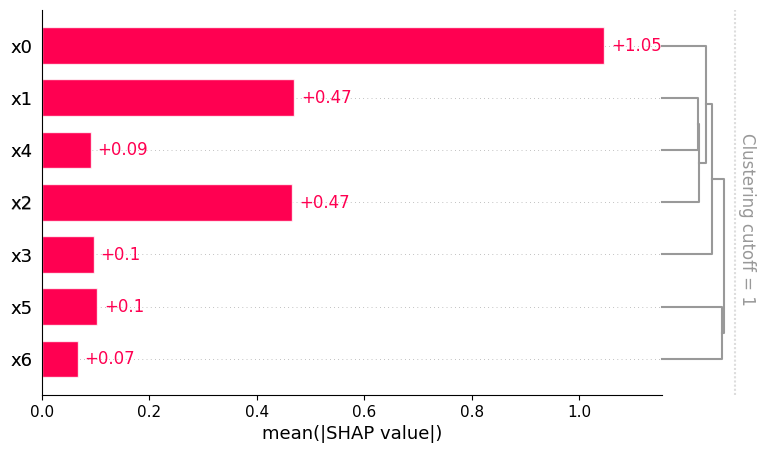

<Figure size 640x480 with 0 Axes>


=== XGB — XGBRegressor ===


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


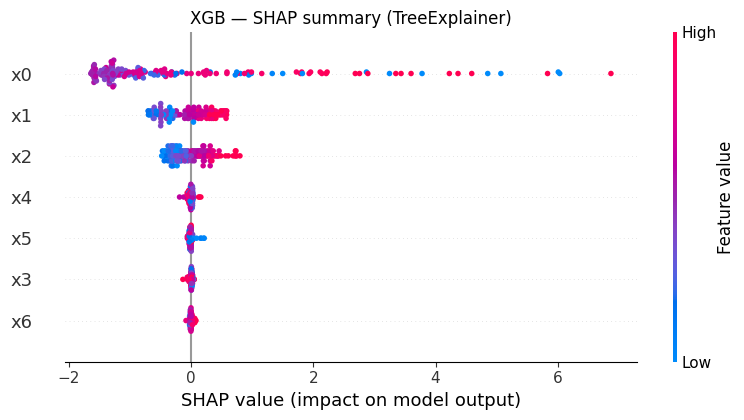

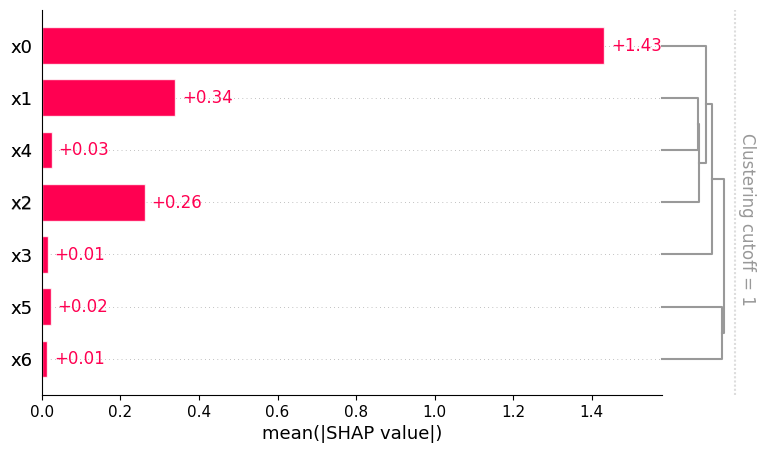

<Figure size 640x480 with 0 Axes>


=== SymReg — SymbolicRegressor ===


  0%|          | 0/157 [00:00<?, ?it/s]

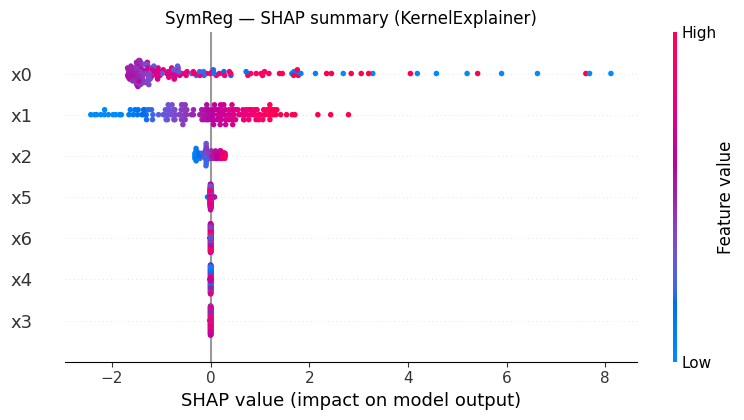

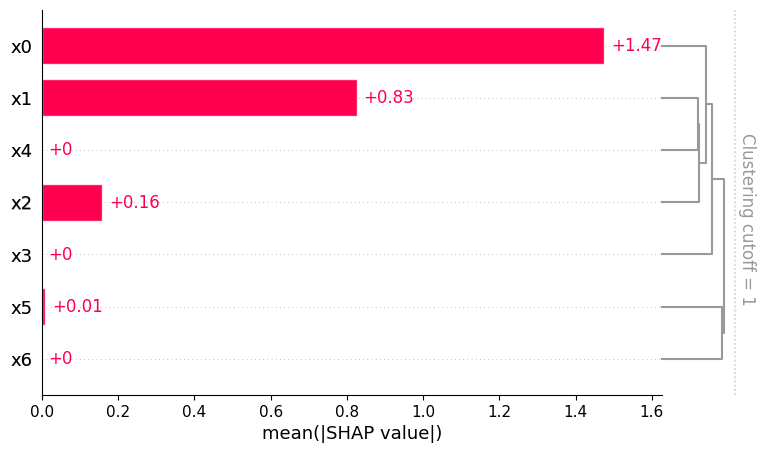

<Figure size 640x480 with 0 Axes>

In [ ]:
# ---- Run it on your winners ----
shap_best_for_all(best_models, splits, xcols, nsamples_kernel=100, do_clustered_bar=True)

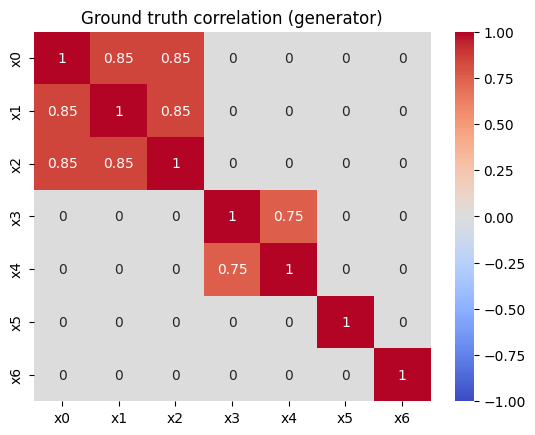

In [ ]:
import itertools, numpy as np, seaborn as sns, matplotlib.pyplot as plt

d = 7
C_true = np.eye(d)

# group1 (x0,x1,x2)
for i,j in itertools.combinations([0,1,2],2):
    C_true[i,j] = C_true[j,i] = 0.85

# group2 (x3,x4)
for i,j in itertools.combinations([3,4],2):
    C_true[i,j] = C_true[j,i] = 0.75

# x5, x6 remain independent

sns.heatmap(C_true, annot=True, vmin=-1, vmax=1, cmap="coolwarm",
            xticklabels=xcols, yticklabels=xcols)
plt.title("Ground truth correlation (generator)")
plt.show()


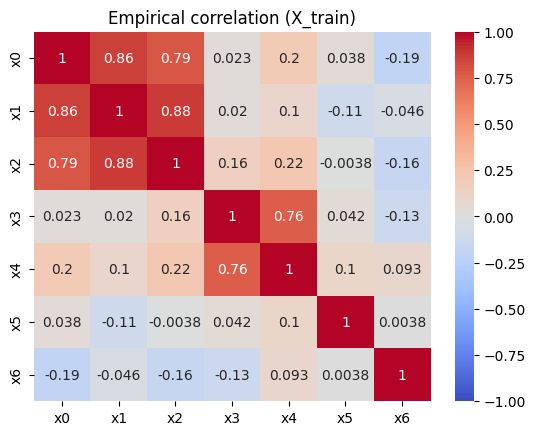

In [ ]:
Xtr, Xte, ytr, yte = splits

emp_corr = pd.DataFrame(Xtr, columns=xcols).corr()

sns.heatmap(emp_corr, annot=True, vmin=-1, vmax=1, cmap="coolwarm")
plt.title("Empirical correlation (X_train)")
plt.show()

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, shap
import itertools
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import adjusted_rand_score

def _true_corr_from_groups(d, groups, rhos):
    C = np.eye(d, dtype=float)
    for g, rho in zip(groups, rhos):
        for i,j in itertools.combinations(g, 2):
            C[i,j] = C[j,i] = float(rho)
    return C

def _mantel_like(A, B):
    iu = np.triu_indices_from(A, k=1)
    a, b = A[iu].ravel(), B[iu].ravel()
    den = np.std(a)*np.std(b)
    return float(np.corrcoef(a, b)[0,1]) if den>0 else np.nan

def compare_shap_corr_to_truth(Xtr, xcols, *, groups, rhos, cutoff_grid=None, method="average"):
    """
    Compare SHAP's correlation clustering to ground truth.
    groups: list of lists (e.g., [[0,1,2],[3,4]])
    rhos:   list of floats (same length as groups)
    """
    d = len(xcols)

    # --- 1) Ground truth & empirical correlations
    C_true = _true_corr_from_groups(d, groups, rhos)
    C_emp  = np.corrcoef(Xtr, rowvar=False)

    # --- 2) Distances used for clustering: D = 1 - |corr|
    D_true = 1 - np.abs(C_true)
    D_emp  = 1 - np.abs(C_emp)

    # --- 3) Linkages
    Z_true = linkage(squareform(D_true, checks=False), method=method)
    # SHAP linkage (same as correlation-based clustering)
    Z_shap = shap.utils.hclust(Xtr, metric="correlation")

    # --- 4) Similarity metrics
    mantel = _mantel_like(C_true, C_emp)

    # ARI across cutoffs
    if cutoff_grid is None:
        heights = np.r_[Z_true[:,2], Z_shap[:,2]]
        lo, hi = float(np.min(heights)), float(np.max(heights))
        cutoff_grid = np.linspace(lo, hi, 25)

    best = (-1.0, None)
    for t in cutoff_grid:
        lab_true = fcluster(Z_true, t=float(t), criterion="distance")
        lab_shap = fcluster(Z_shap, t=float(t), criterion="distance")
        ari = adjusted_rand_score(lab_true, lab_shap)
        if ari > best[0]:
            best = (ari, t)
    best_ari, best_t = float(best[0]), float(best[1])

    # --- 5) Plots
    fig, ax = plt.subplots(1,2, figsize=(8.8,3.6))
    im0 = ax[0].imshow(C_true, vmin=-1, vmax=1, cmap="coolwarm"); ax[0].set_title("True corr")
    ax[0].set_xticks(range(d)); ax[0].set_yticks(range(d))
    ax[0].set_xticklabels(xcols, rotation=45, ha="right"); ax[0].set_yticklabels(xcols)
    plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    im1 = ax[1].imshow(C_emp, vmin=-1, vmax=1, cmap="coolwarm"); ax[1].set_title("Empirical corr (X_train)")
    ax[1].set_xticks(range(d)); ax[1].set_yticks(range(d))
    ax[1].set_xticklabels(xcols, rotation=45, ha="right"); ax[1].set_yticklabels(xcols)
    plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)
    plt.suptitle(f"Mantel-like corr (off-diagonals): {mantel:.3f}")
    plt.tight_layout(); plt.show()

    # Dendrograms with common cutoff
    fig, ax = plt.subplots(1,2, figsize=(9.6,3.6))
    dendrogram(Z_true, labels=xcols, ax=ax[0], color_threshold=best_t); ax[0].set_title("True dendrogram")
    dendrogram(Z_shap, labels=xcols, ax=ax[1], color_threshold=best_t); ax[1].set_title(f"SHAP dendrogram (best ARI t={best_t:.2f})")
    plt.tight_layout(); plt.show()

    print(f"Similarity metrics:\n  Mantel-like corr (C_true vs C_emp) = {mantel:.3f}\n  Best ARI (true vs SHAP clusters)   = {best_ari:.3f} at cutoff t = {best_t:.2f}")

    # Also return the labels at that cutoff for quick inspection
    lab_true = fcluster(Z_true, t=best_t, criterion="distance")
    lab_shap = fcluster(Z_shap, t=best_t, criterion="distance")
    return {
        "C_true": C_true, "C_emp": C_emp,
        "Z_true": Z_true, "Z_shap": Z_shap,
        "mantel_like": mantel, "best_ari": best_ari, "best_cutoff": best_t,
        "labels_true": dict(zip(xcols, map(int, lab_true))),
        "labels_shap": dict(zip(xcols, map(int, lab_shap))),
    }


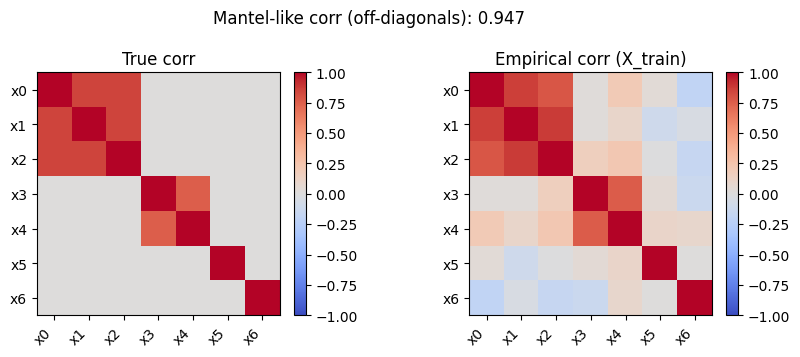

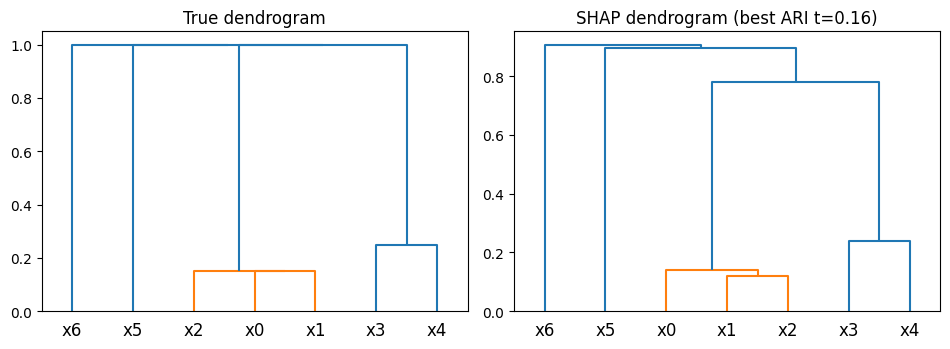

Similarity metrics:
  Mantel-like corr (C_true vs C_emp) = 0.947
  Best ARI (true vs SHAP clusters)   = 1.000 at cutoff t = 0.16

Cluster labels at best cutoff:
True: {'x0': 1, 'x1': 1, 'x2': 1, 'x3': 2, 'x4': 3, 'x5': 4, 'x6': 5}
SHAP: {'x0': 1, 'x1': 1, 'x2': 1, 'x3': 2, 'x4': 3, 'x5': 4, 'x6': 5}


In [ ]:
# Unpack the split produced by run_model_search
Xtr, Xte, ytr, yte = splits

# Match your generator: e.g., x0–x2 @ 0.85, x3–x4 @ 0.75, x5 & x6 independent
res_cmp = compare_shap_corr_to_truth(
    Xtr, xcols,
    groups=[[0,1,2],[3,4]],
    rhos=[0.85, 0.75]
)

print("\nCluster labels at best cutoff:")
print("True:", res_cmp["labels_true"])
print("SHAP:", res_cmp["labels_shap"])


In [ ]:
# ==== SCALING ABLATION: predictions & SHAP (one model) ====
import numpy as np, pandas as pd, matplotlib.pyplot as plt, shap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, KFold

# --- utilities ---
def _scores(y_true, y_pred):
    return dict(
        R2=float(r2_score(y_true, y_pred)),
        RMSE=float(np.sqrt(mean_squared_error(y_true, y_pred))),
        MAE=float(mean_absolute_error(y_true, y_pred)),
    )

def _predict_fn(pipe):
    # KernelExplainer will pass RAW X; pipeline handles scaling internally.
    return lambda XR: pipe.predict(XR)

def _build_linkage(X_train, y_train=None):
    try:
        return shap.utils.hclust(X_train, y_train)
    except TypeError:
        return shap.utils.hclust(X_train, metric="correlation")

def _to_explanation(sv, X_for_plot, feature_names):
    sv = sv[0] if isinstance(sv, list) else sv
    return shap.Explanation(
        values=np.asarray(sv),
        base_values=np.zeros(len(X_for_plot)),
        data=X_for_plot,
        feature_names=feature_names
    )

def _clustered_bar(explanation, linkage, title, cutoff=1.0):
    drew = False
    try:
        fig, ax = plt.subplots(figsize=(6,4))
        shap.plots.bar(explanation, max_display=12, clustering=linkage, clustering_cutoff=float(cutoff))
        drew = len(ax.patches) > 0 or len(ax.containers) > 0
        if drew:
            ax.set_title(title); plt.tight_layout(); plt.show()
        else:
            plt.close(fig)
    except Exception:
        try: plt.close(fig)
        except Exception: pass
        drew = False

    if not drew:
        # robust manual fallback (group mean|SHAP| by clusters)
        from scipy.cluster.hierarchy import fcluster, leaves_list
        sv = explanation.values
        mean_abs = np.mean(np.abs(sv), axis=0)
        clusters = fcluster(linkage, t=float(cutoff), criterion="distance")
        groups = {}
        for j, cid in enumerate(clusters): groups.setdefault(int(cid), []).append(j)
        vals, labels = [], []
        for cid, idxs in groups.items():
            vals.append(float(mean_abs[idxs].sum()))
            labels.append(explanation.feature_names[idxs[0]] if len(idxs)==1
                          else explanation.feature_names[idxs[0]]+f" (+{len(idxs)-1})")
        order = np.argsort(vals)[::-1]; vals = np.array(vals)[order]; labels = [labels[i] for i in order]
        y = np.arange(len(labels))
        plt.figure(figsize=(6, max(3, 0.35*len(labels))))
        plt.barh(y, vals); plt.yticks(y, labels); plt.gca().invert_yaxis()
        plt.xlabel("mean |SHAP| (grouped)"); plt.title(title); plt.tight_layout(); plt.show()

def scaling_ablation_on_model(
    splits, xcols, *,
    model_kind="SVR-RBF",
    use_best_params_from=None,   # pass best_models dict if you want Mode A (fixed params)
    refit_hyperparams=False,     # set True for Mode B (search per scaler)
    nsamples_kernel=80,
    random_state=7
):
    """
    Compare 3 pipelines of the SAME model:
      1) Standardize (mean=0, std=1), 2) MinMax [0,1], 3) Raw (no scaling).
    Plots: metrics table, SHAP summaries, and clustered bars.

    Args:
      splits: (Xtr, Xte, ytr, yte) from your earlier run.
      xcols : feature names list.
      use_best_params_from: dict of {model_name: best_estimator} to pull tuned params (Mode A).
      refit_hyperparams: if True, RandomizedSearchCV per scaler (Mode B).
    """
    assert model_kind in ["SVR-RBF", "Ridge", "MLP"], "Demo supports 'SVR-RBF', 'Ridge', or 'MLP'."

    Xtr, Xte, ytr, yte = splits
    results = []
    variants = []

    # --- Build three pipelines for the chosen model ---
    if model_kind == "SVR-RBF":
        base = SVR(kernel="rbf")
        pipes = {
            "Standardize(0,1)": Pipeline([("scaler", StandardScaler(with_mean=True, with_std=True)), ("m", base)]),
            "MinMax[0,1]":      Pipeline([("scaler", MinMaxScaler()), ("m", base)]),
            "Raw":              Pipeline([("m", SVR(kernel="rbf"))])
        }
        # default/fallback hyperparams
        default_params = {"m__C": 10.0, "m__gamma": 0.01, "m__epsilon": 0.1}
        search_space = {
            "m__C": np.logspace(-2, 3, 30),
            "m__gamma": np.logspace(-4, 1, 30),
            "m__epsilon": np.logspace(-3, 0, 15),
        }

    elif model_kind == "Ridge":
        from sklearn.linear_model import Ridge
        base = Ridge(random_state=random_state)
        pipes = {
            "Standardize(0,1)": Pipeline([("scaler", StandardScaler(with_mean=True, with_std=True)), ("m", base)]),
            "MinMax[0,1]":      Pipeline([("scaler", MinMaxScaler()), ("m", base)]),
            "Raw":              Pipeline([("m", Ridge(random_state=random_state))])
        }
        default_params = {"m__alpha": 1.0}
        search_space = {"m__alpha": np.logspace(-4, 3, 50)}

    else:  # MLP
        from sklearn.neural_network import MLPRegressor
        base = MLPRegressor(max_iter=800, early_stopping=True, random_state=random_state)
        pipes = {
            "Standardize(0,1)": Pipeline([("scaler", StandardScaler(with_mean=True, with_std=True)), ("m", base)]),
            "MinMax[0,1]":      Pipeline([("scaler", MinMaxScaler()), ("m", base)]),
            "Raw":              Pipeline([("m", MLPRegressor(max_iter=800, early_stopping=True, random_state=random_state))])
        }
        default_params = {"m__hidden_layer_sizes": (128,64), "m__alpha": 1e-4, "m__learning_rate_init": 1e-3}
        search_space = {
            "m__hidden_layer_sizes": [(64,64),(128,64),(128,128)],
            "m__alpha": np.logspace(-6, -2, 7),
            "m__learning_rate_init": np.logspace(-4, -2, 5)
        }

    # Pull tuned params for the chosen model if provided (Mode A)
    tuned = None
    if use_best_params_from is not None:
        # try to find the exact key (e.g., "SVR-RBF", "Ridge", "MLP")
        est = use_best_params_from.get(model_kind)
        if est is None:
            # Some leaderboards keyed like {"SVR-RBF": Pipeline(...)}; otherwise search by class
            for k,v in use_best_params_from.items():
                if model_kind.split("-")[0].lower() in v.__class__.__name__.lower() or model_kind in k:
                    est = v; break
        if est is not None:
            # extract only the "m__*" params so we can set them on each pipeline
            if isinstance(est, Pipeline) and "m" in est.named_steps:
                tuned = {f"m__{k}": v for k,v in est.named_steps["m"].get_params().items()
                         if not isinstance(v, (np.ndarray,))}  # keep simple types
            else:
                tuned = {f"m__{k}": v for k,v in est.get_params().items()
                         if not isinstance(v, (np.ndarray,))}
    # Fallback defaults if no tuned params were found
    if tuned is None:
        tuned = default_params

    # Optional per-scaler refit (Mode B)
    if refit_hyperparams:
        cv = KFold(n_splits=4, shuffle=True, random_state=random_state)
        for name, pipe in pipes.items():
            rs = RandomizedSearchCV(pipe, param_distributions=search_space, n_iter=25, cv=cv,
                                    scoring="r2", n_jobs=-1, random_state=random_state, verbose=0, refit=True)
            rs.fit(Xtr, ytr)
            pipes[name] = rs.best_estimator_
            print(f"{model_kind} @ {name}: re-tuned best CV R2={rs.best_score_:.3f}")
    else:
        # Just set the same model hyperparams on each pipeline (scaler effect only)
        for name, pipe in pipes.items():
            pipe.set_params(**tuned)
            pipe.fit(Xtr, ytr)

    # Build one correlation tree (on full data for stability; change to Xtr if you want strict train-only)
    linkage = _build_linkage(np.vstack([Xtr, Xte]))

    # Evaluate + SHAP
    for name, pipe in pipes.items():
        if refit_hyperparams and not hasattr(pipe, "predict"):
            # if pipe was replaced by best_estimator_, ensure it's fitted
            pipe.fit(Xtr, ytr)

        yhat = pipe.predict(Xte)
        s = _scores(yte, yhat); s["variant"] = name
        results.append(s)
        variants.append((name, pipe))

        # KernelExplainer for SVR/MLP; for Ridge we’ll use LinearExplainer
        model_cls = pipe.named_steps["m"].__class__.__name__.lower() if isinstance(pipe, Pipeline) else pipe.__class__.__name__.lower()
        print(f"\n[{model_kind} | {name}] TEST: { {k:round(s[k],4) for k in ['R2','RMSE','MAE']} }")

        try:
            if "ridge" in model_cls:
                # Ridge: work in pipeline space (scaler inside), plot vs RAW X
                # Build arrays pipeline expects
                scaler = pipe.named_steps.get("scaler", None)
                if scaler is not None:
                    Xtr_s = scaler.transform(Xtr)   # NO re-fit here
                    Xte_s = scaler.transform(Xte)
                else:
                    Xtr_s, Xte_s = Xtr, Xte

                explainer = shap.LinearExplainer(pipe.named_steps["m"], Xtr_s, feature_names=xcols)
                sv = explainer.shap_values(Xte_s)
                shap.summary_plot(sv, Xte, feature_names=xcols, show=False)
                plt.title(f"{model_kind} | {name} — SHAP summary (LinearExplainer)"); plt.tight_layout(); plt.show()
                ex = _to_explanation(sv, Xte, xcols)
            else:
                # SVR / MLP → KernelExplainer
                f = _predict_fn(pipes[name])
                bg = Xtr if len(Xtr) <= 200 else Xtr[np.random.choice(len(Xtr), 200, replace=False)]
                explainer = shap.KernelExplainer(f, bg)
                sv = explainer.shap_values(Xte, nsamples=nsamples_kernel)
                shap.summary_plot(sv, Xte, feature_names=xcols, show=False)
                plt.title(f"{model_kind} | {name} — SHAP summary (KernelExplainer)"); plt.tight_layout(); plt.show()
                ex = _to_explanation(sv, Xte, xcols)

            _clustered_bar(ex, linkage, title=f"{model_kind} | {name} — Clustered SHAP bar", cutoff=1.0)

        except Exception as e:
            print(f"SHAP failed for {model_kind} | {name}: {e}")

    # Metrics table
    df_res = pd.DataFrame(results).sort_values("R2", ascending=False)
    print("\n=== Scaling ablation leaderboard (TEST) ===")
    display(df_res[["variant","R2","RMSE","MAE"]])




[SVR-RBF | Standardize(0,1)] TEST: {'R2': -219.4599, 'RMSE': 32.8298, 'MAE': 22.605}


  0%|          | 0/157 [00:00<?, ?it/s]

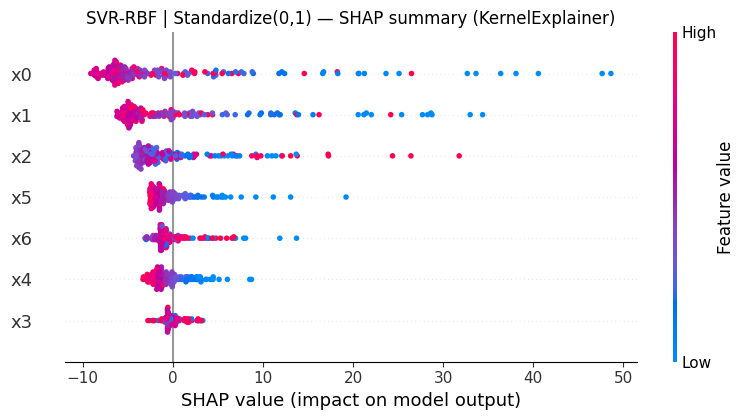

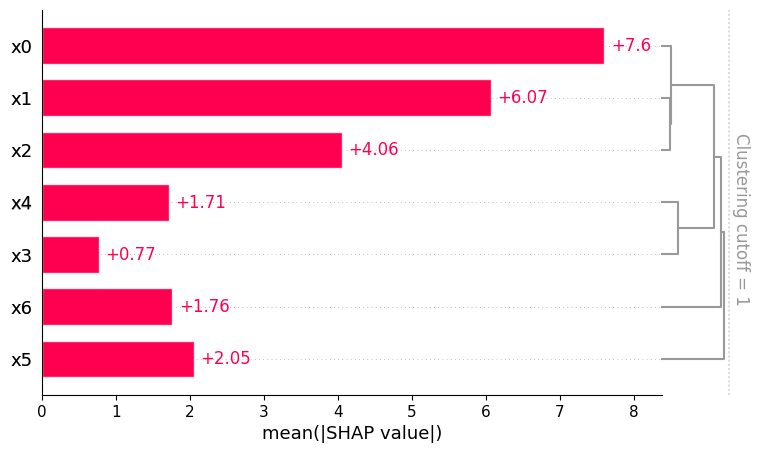

<Figure size 640x480 with 0 Axes>


[SVR-RBF | MinMax[0,1]] TEST: {'R2': 0.7427, 'RMSE': 1.1216, 'MAE': 0.7267}


  0%|          | 0/157 [00:00<?, ?it/s]

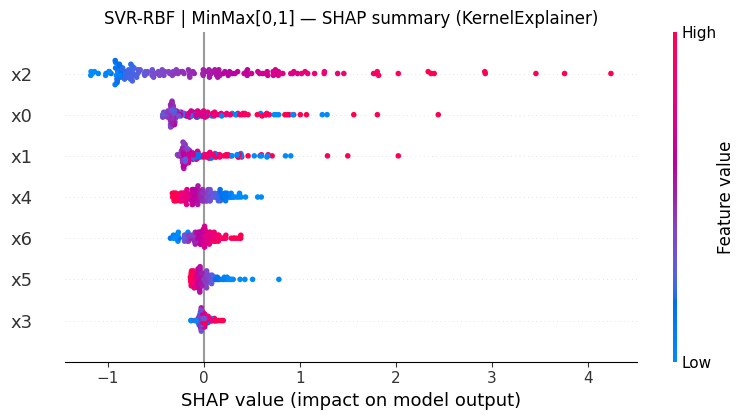

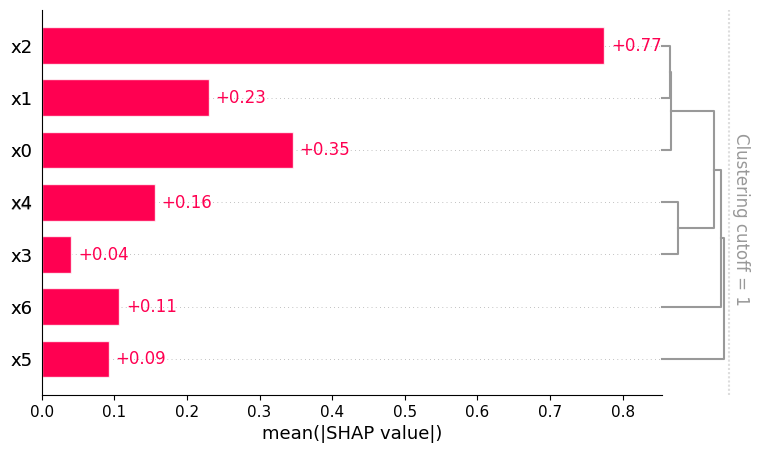

<Figure size 640x480 with 0 Axes>


[SVR-RBF | Raw] TEST: {'R2': 0.9879, 'RMSE': 0.243, 'MAE': 0.188}


  0%|          | 0/157 [00:00<?, ?it/s]

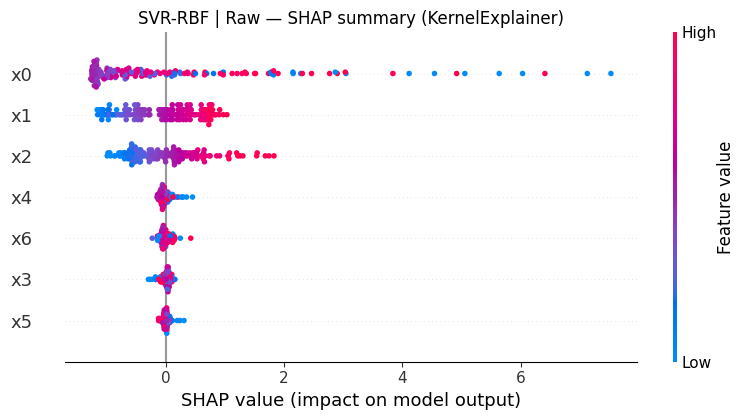

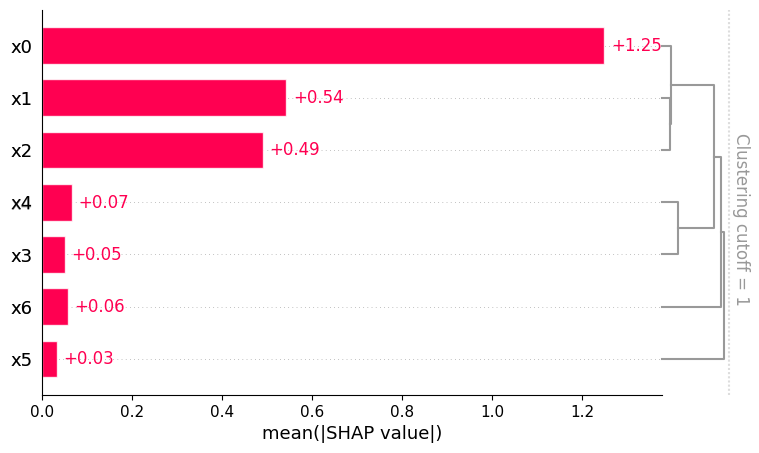

<Figure size 640x480 with 0 Axes>


=== Scaling ablation leaderboard (TEST) ===


,variant,R2,RMSE,MAE
2,Raw,0.987919,0.243026,0.188023
1,"MinMax[0,1]",0.742669,1.121630,0.726682
0,"Standardize(0,1)",-219.459920,32.829812,22.604960


In [ ]:
# ---- RUN IT ----
# Uses your earlier train/test split & feature names:
#    splits = (Xtr, Xte, ytr, yte)
#    xcols  = [...]
# If you have best_models from the earlier search, pass it for Mode A.
# Example 1: SVR fixed hyperparams (isolates scaling effect)
scaling_ablation_on_model(splits, xcols, model_kind="SVR-RBF",
                          use_best_params_from=best_models,  # Mode A (fixed)
                          refit_hyperparams=False,           # set True for Mode B
                          nsamples_kernel=80)

# Example 2: try Ridge (linear) or MLP as well, one at a time:
# scaling_ablation_on_model(splits, xcols, model_kind="Ridge",
#                           use_best_params_from=best_models, refit_hyperparams=False)
# scaling_ablation_on_model(splits, xcols, model_kind="MLP",
#                           use_best_params_from=best_models, refit_hyperparams=True)


MLP @ Standardize(0,1): re-tuned best CV R2=0.978
MLP @ MinMax[0,1]: re-tuned best CV R2=0.977


MLP @ Raw: re-tuned best CV R2=0.978

[MLP | Standardize(0,1)] TEST: {'R2': 0.9853, 'RMSE': 0.2679, 'MAE': 0.209}


  0%|          | 0/157 [00:00<?, ?it/s]

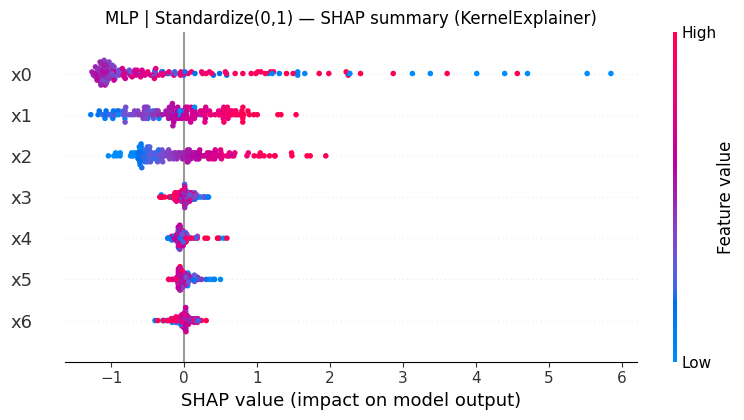

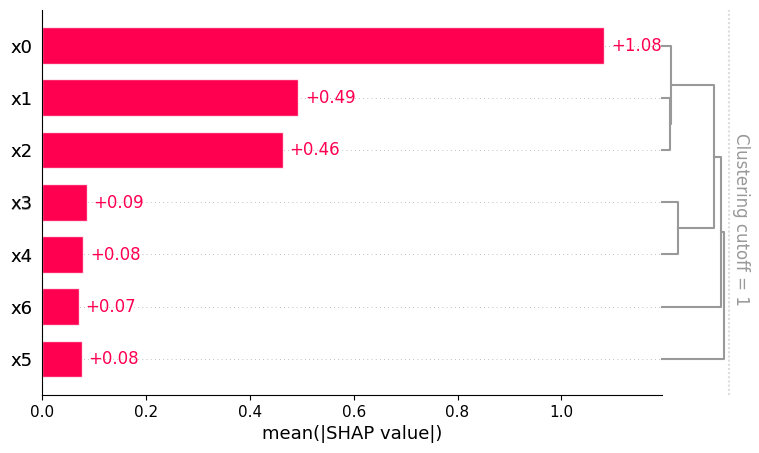

<Figure size 640x480 with 0 Axes>


[MLP | MinMax[0,1]] TEST: {'R2': 0.9846, 'RMSE': 0.2744, 'MAE': 0.2178}


  0%|          | 0/157 [00:00<?, ?it/s]

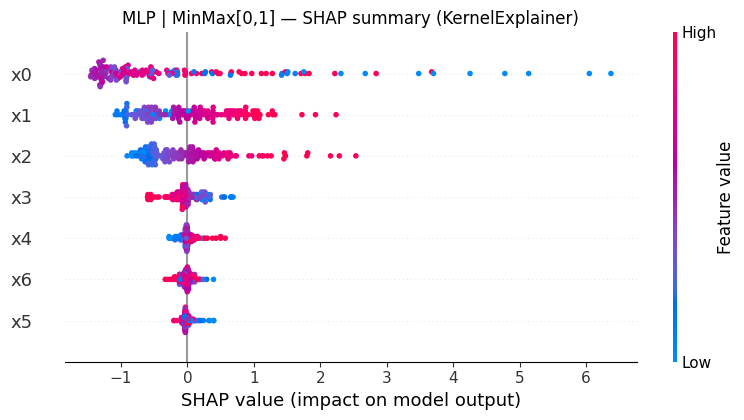

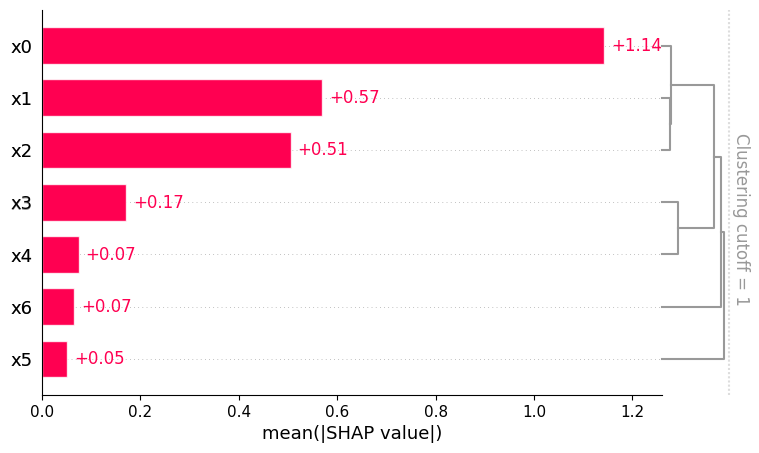

<Figure size 640x480 with 0 Axes>


[MLP | Raw] TEST: {'R2': 0.9861, 'RMSE': 0.2611, 'MAE': 0.2032}


  0%|          | 0/157 [00:00<?, ?it/s]

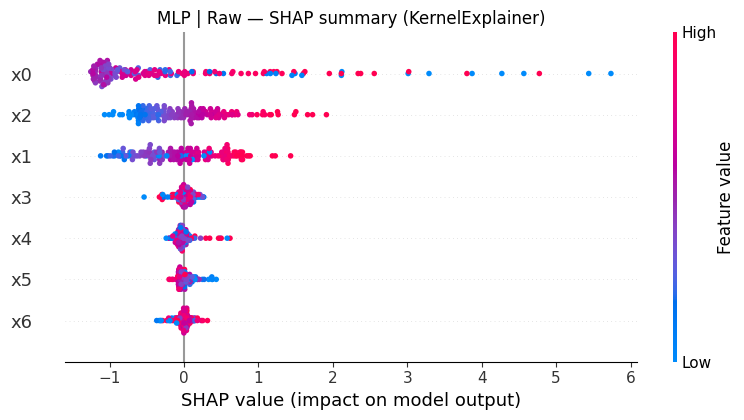

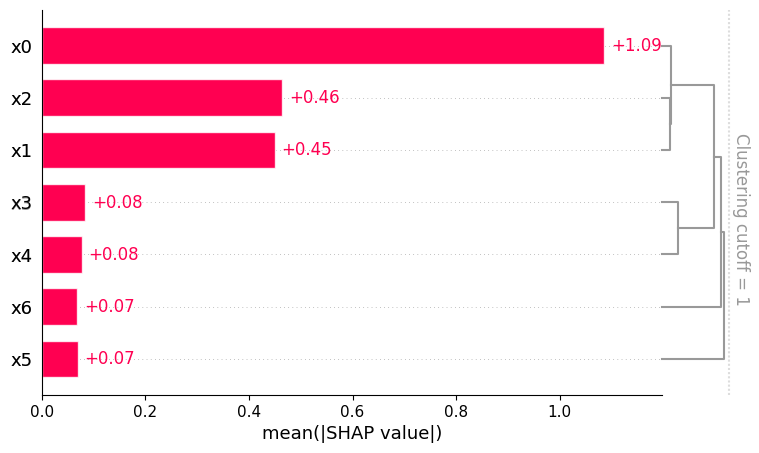

<Figure size 640x480 with 0 Axes>


=== Scaling ablation leaderboard (TEST) ===


,variant,R2,RMSE,MAE
2,Raw,0.986059,0.261064,0.203171
0,"Standardize(0,1)",0.985316,0.267932,0.209046
1,"MinMax[0,1]",0.984601,0.274378,0.217786


In [ ]:
#MLP
scaling_ablation_on_model(splits, xcols, model_kind="MLP",
                          use_best_params_from=best_models, refit_hyperparams=True)

#NO

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import itertools, textwrap

plt.rcParams["figure.figsize"] = (6.0, 4.5)
RNG = np.random.default_rng(42)

In [ ]:
def build_corr(d, mode="independent", rho=0.85, groups=None):
    """
    Return a d×d correlation matrix for feature simulation (unit variances).
      - 'independent' → identity
      - 'pair'        → correlate x0 & x1 with rho
      - 'groups'      → correlate features within each group with rho (e.g., [[0,1,2],[3,4]])
    """
    C = np.eye(d)
    if mode == "pair":
        C[0,1] = C[1,0] = rho
    elif mode == "groups" and groups:
        for g in groups:
            for i, j in itertools.combinations(g, 2):
                C[i, j] = C[j, i] = rho
    return C

def synth_function(X_unscaled, kind="quad_sin"):
    """
    Define the *true* target on underlying (unscaled) features.
    Returns (f_noiseless, meta).
    """
    X = np.asarray(X_unscaled, float)
    n, d = X.shape
    if d < 4:
        X = np.hstack([X, np.zeros((n, 4-d))])

    if kind == "linear":
        w = np.linspace(1.0, 0.2, X.shape[1])
        f = X @ w; used = list(range(X.shape[1])); formula = "y = Σ_j w_j * x_j"
    elif kind == "quad_sin":
        f = 1.5*(X[:,0]**2) + np.sin(X[:,1]) + 0.5*X[:,2]
        used = [0,1,2]; formula = "y = 1.5*x0^2 + sin(x1) + 0.5*x2"
    elif kind == "interaction":
        f = X[:,0]*X[:,1] + 0.7*X[:,2] - 0.5*X[:,3]
        used = [0,1,2,3]; formula = "y = x0*x1 + 0.7*x2 - 0.5*x3"
    elif kind == "symbolic":
        f = np.exp(-X[:,0]) * np.cos(X[:,1]) + 0.2*X[:,2]
        used = [0,1,2]; formula = "y = exp(-x0) * cos(x1) + 0.2*x2"
    else:
        f = X[:,0]; used = [0]; formula = "y = x0"
    return f, {"target_kind": kind, "target_formula": formula, "target_features": used}

def make_dataset(
    n=800, d=6,
    corr_mode="independent", rho=0.0, groups=None,
    target_kind="quad_sin", noise_sigma=0.25, seed=7
):
    """
    Returns RAW df (x0..x{d-1}, y) + meta.
    X ~ N(0, Σ) with Σ from build_corr; y = f(X) + ε.
    meta['covariance'] stores the TRUE correlation matrix (ground truth).
    """
    rng = np.random.default_rng(seed)
    C = build_corr(d, corr_mode, rho, groups)   # ground-truth correlation
    X_raw = rng.multivariate_normal(np.zeros(d), C, size=n)
    f, tmeta = synth_function(X_raw, target_kind)
    y = f + rng.normal(0, noise_sigma, size=n)

    cols = [f"x{i}" for i in range(d)]
    df = pd.DataFrame(X_raw, columns=cols)
    df["y"] = y

    meta = {
        "n": n, "d": d,
        "corr_mode": corr_mode, "rho": rho, "groups": groups,
        "noise_sigma": noise_sigma, "seed": seed,
        "covariance": C.tolist(),
    }
    meta.update(tmeta)
    return df, meta

def show_ground_truth(df, meta, title="Dataset"):
    """
    Display: brief meta, first rows, and heatmaps:
      (1) TRUE correlation (generator), (2) EMPIRICAL correlation (sample),
      (3) difference.
    """
    xcols = [c for c in df.columns if c != "y"]
    X = df[xcols].to_numpy()
    R_emp  = np.corrcoef(X, rowvar=False)
    R_true = np.array(meta["covariance"], float)

    print(f"\n=== {title} ===")
    print(f"Samples: {len(df)}  Features: {len(xcols)}   Inputs: {xcols}   Target: 'y'")
    print(f"Target: {meta['target_kind']}  |  Formula: {meta['target_formula']}")
    print(f"Correlation mode: {meta['corr_mode']}  rho: {meta['rho']}  groups: {meta['groups']}")
    print("Preview:")
    display(df.head())

    # Heatmaps
    fig, axes = plt.subplots(1, 3, figsize=(13, 3.8))
    for ax, M, ttl in zip(
        axes,
        [R_true, R_emp, R_emp - R_true],
        ["True correlation (generator)", "Empirical correlation (sample)", "Empirical − True"]
    ):
        im = ax.imshow(M, vmin=-1, vmax=1, cmap="coolwarm")
        ax.set_title(ttl)
        ax.set_xticks(range(len(xcols))); ax.set_yticks(range(len(xcols)))
        ax.set_xticklabels(xcols, rotation=45, ha="right"); ax.set_yticklabels(xcols)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.suptitle(title); plt.tight_layout(); plt.show()


=== GROUND TRUTH — Uncorrelated (independent) ===
Samples: 800  Features: 6   Inputs: ['x0', 'x1', 'x2', 'x3', 'x4', 'x5']   Target: 'y'
Target: quad_sin  |  Formula: y = 1.5*x0^2 + sin(x1) + 0.5*x2
Correlation mode: independent  rho: 0.0  groups: None
Preview:


,x0,x1,x2,x3,x4,x5,y
0,0.034193,1.359748,1.224721,-0.510307,-0.297970,-0.527384,1.348541
1,0.569726,-0.056064,0.746886,-1.847325,1.566549,-0.096432,0.840411
2,0.680378,-0.136566,-0.379099,0.463110,0.824514,-0.202530,0.032646
3,-0.152786,0.685699,-0.870341,-1.514384,0.394982,-0.670566,0.657272
4,-1.920341,-0.814054,-0.467598,-1.193202,-1.492464,0.036638,4.578406


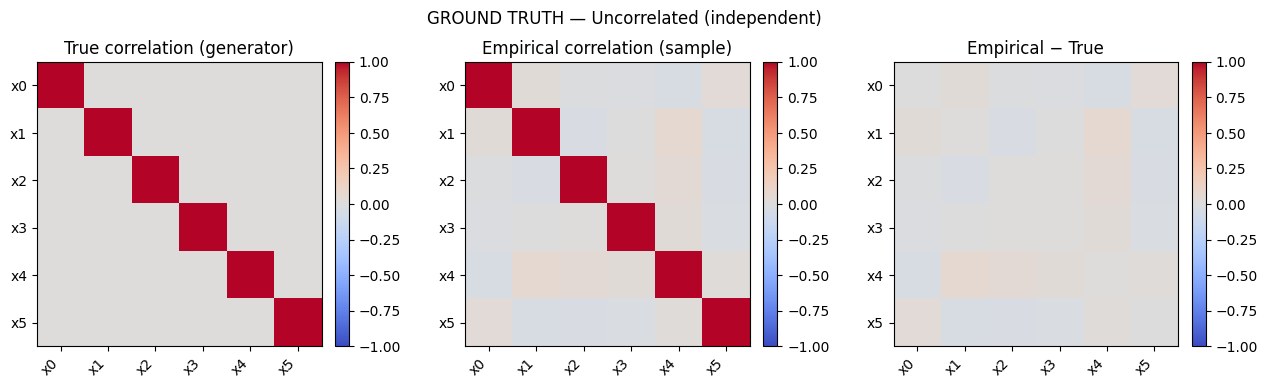


=== GROUND TRUTH — Correlated groups (ρ=0.85, [0,1,2] & [3,4]) ===
Samples: 800  Features: 6   Inputs: ['x0', 'x1', 'x2', 'x3', 'x4', 'x5']   Target: 'y'
Target: quad_sin  |  Formula: y = 1.5*x0^2 + sin(x1) + 0.5*x2
Correlation mode: groups  rho: 0.85  groups: [[0, 1, 2], [3, 4]]
Preview:


,x0,x1,x2,x3,x4,x5,y
0,-0.199212,0.132551,-0.030654,-1.168010,-1.447517,1.224721,-0.067021
1,-0.570984,-0.954260,-0.096226,0.559832,-0.451990,0.746886,-0.338842
2,-0.709509,-0.839243,-0.387639,0.004517,0.258173,-0.379099,-0.518887
3,-0.067106,0.142801,0.359142,-0.244753,-1.074215,-0.870341,0.752855
4,1.833381,2.224730,1.407274,1.109704,0.456160,-0.467598,6.546981


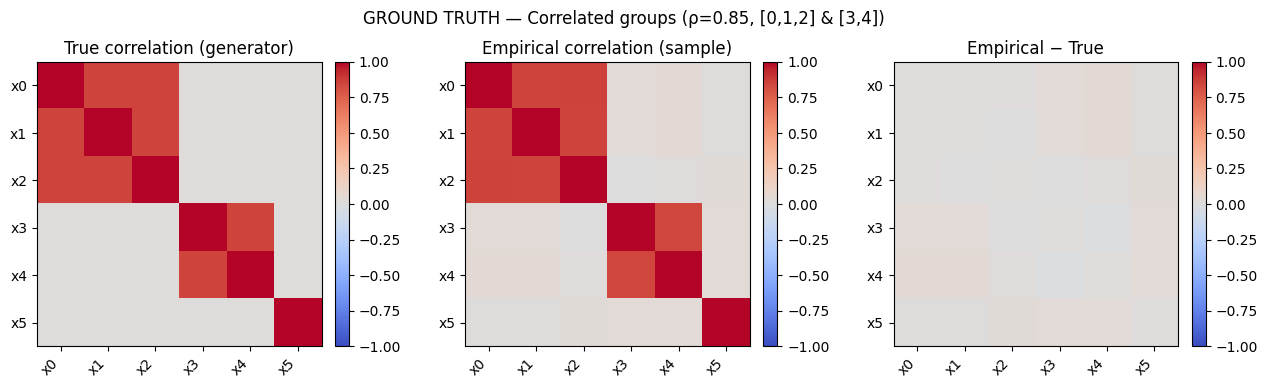

In [ ]:
# ---- Generate one uncorrelated and one correlated dataset (same target) ----
UNCORRELATED_CFG = dict(n=800, d=6, corr_mode="independent", rho=0.0, groups=None,
                        target_kind="quad_sin", noise_sigma=0.25, seed=11)
CORRELATED_CFG   = dict(n=800, d=6, corr_mode="groups", rho=0.85, groups=[[0,1,2],[3,4]],
                        target_kind="quad_sin", noise_sigma=0.25, seed=11)

df_unc, meta_unc   = make_dataset(**UNCORRELATED_CFG)
df_corr, meta_corr = make_dataset(**CORRELATED_CFG)

# ---- Display ground truth & samples ----
show_ground_truth(df_unc,  meta_unc,  title="GROUND TRUTH — Uncorrelated (independent)")
show_ground_truth(df_corr, meta_corr, title="GROUND TRUTH — Correlated groups (ρ=0.85, [0,1,2] & [3,4])")

In [ ]:
# ==== FEATURE/TARGET MAPS ====
import numpy as np, matplotlib.pyplot as plt
from math import ceil, sqrt

try:
    from scipy.interpolate import griddata
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

def _best_grid(n):
    """Rows, cols for a near-square tiling of n samples."""
    cols = int(ceil(sqrt(n)))
    rows = int(ceil(n / cols))
    return rows, cols

def _paginate(ax_count, per_fig=8):
    pages = int(ceil(ax_count / per_fig))
    # returns slice indices [(0, per_fig), (per_fig, 2*per_fig), ...]
    return [(i*per_fig, min((i+1)*per_fig, ax_count)) for i in range(pages)]

def _plot_tiles(tiles, names, cmap="viridis", title_prefix=""):
    """tiles: list of 2D arrays; names: titles per tile"""
    per_fig = 8
    for a, b in _paginate(len(tiles), per_fig=per_fig):
        chunk = tiles[a:b]
        labels = names[a:b]
        n = len(chunk)
        ncols = 4
        nrows = int(ceil(n / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.8*nrows))
        axes = np.atleast_2d(axes).ravel()
        for ax, Z, lab in zip(axes, chunk, labels):
            im = ax.imshow(Z, aspect="equal", origin="upper", cmap=cmap)
            ax.set_title(f"{title_prefix}{lab}", fontsize=10)
            ax.set_xticks([]); ax.set_yticks([])
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        for ax in axes[len(chunk):]:
            ax.axis("off")
        plt.tight_layout()
        plt.show()

def feature_target_maps(df, *, cols=None, coords=None, grid_res=None, cmap="viridis", title_prefix=""):
    """
    Visualize each selected feature (and 'y' if present) as a heatmap.

    - If coords is None: lays samples on a near-square index grid.
    - If coords=(x, y): interpolates scattered points to a regular grid (needs SciPy).

    Args:
      df: DataFrame with columns x0..xd-1 and optionally 'y'
      cols: list of column names to plot; default = all numeric
      coords: tuple (x, y) arrays of same length as df (optional)
      grid_res: (ny, nx) for interpolation; default chosen from sample count
      cmap: matplotlib colormap name
    """
    if cols is None:
        cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
    # keep ordering x0.. then y at end if present
    cols = sorted([c for c in cols if c != "y"]) + ([ "y" ] if "y" in df.columns and ("y" in (cols or [])) or "y" not in cols else [])

    vals = df[cols].to_numpy()
    n = len(df)

    if coords is None:
        # --- index grid layout ---
        rows, cols_grid = _best_grid(n)
        pad = rows*cols_grid - n
        tiles, names = [], []
        for j, name in enumerate(df[cols].columns):
            v = vals[:, j]
            if pad > 0:
                v = np.r_[v, [np.nan]*pad]
            Z = v.reshape(rows, cols_grid)
            tiles.append(Z)
            names.append(name)
        _plot_tiles(tiles, names, cmap=cmap, title_prefix=title_prefix)
    else:
        # --- scattered -> regular grid via interpolation ---
        if not _HAS_SCIPY:
            raise RuntimeError("SciPy is required for coordinate interpolation (scipy.interpolate.griddata not found).")
        x, y = coords
        x = np.asarray(x).ravel(); y = np.asarray(y).ravel()
        assert len(x) == n and len(y) == n, "coords must match number of rows in df"
        if grid_res is None:
            g = int(round(sqrt(n)))
            grid_res = (g, g)
        ny, nx = grid_res
        xi = np.linspace(np.min(x), np.max(x), nx)
        yi = np.linspace(np.min(y), np.max(y), ny)
        XI, YI = np.meshgrid(xi, yi)

        tiles, names = [], []
        for j, name in enumerate(df[cols].columns):
            v = vals[:, j]
            Zi = griddata((x, y), v, (XI, YI), method="linear")
            tiles.append(Zi)
            names.append(name)
        _plot_tiles(tiles, names, cmap=cmap, title_prefix=title_prefix)




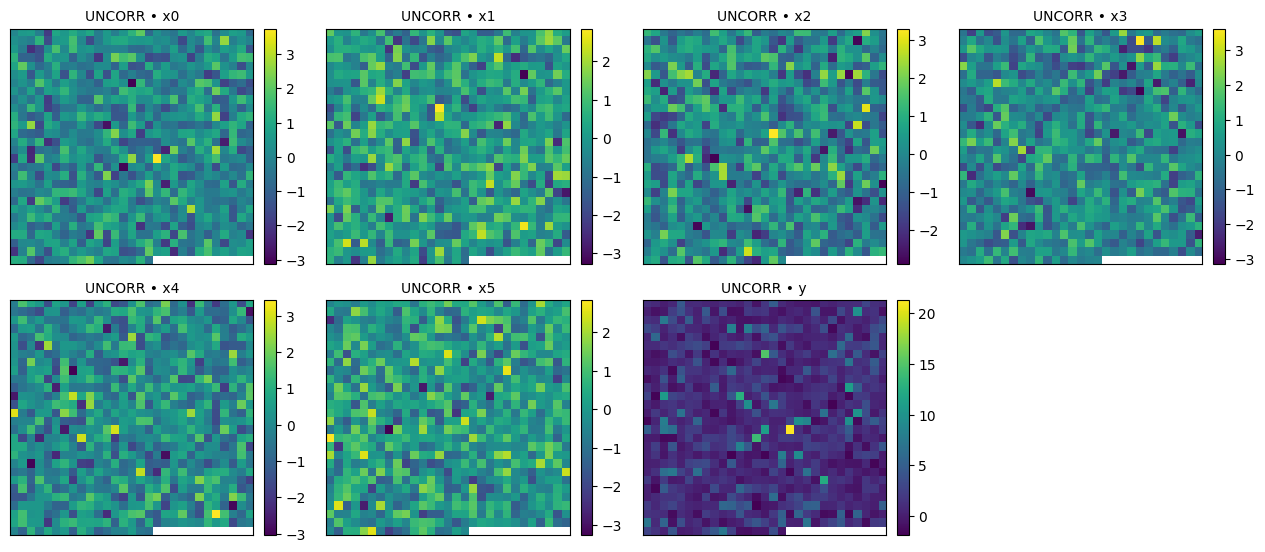

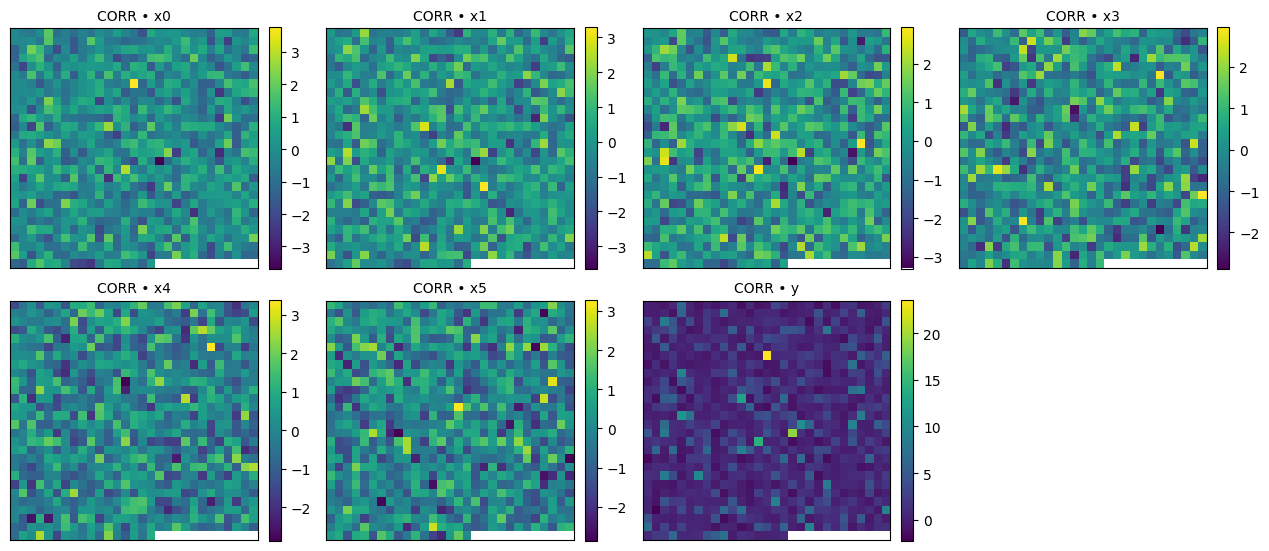

In [ ]:
# ---- Usage (index grid; no coordinates) ----
# Plots maps for x0..x5 and y using the current df and df_corr, for example:
feature_target_maps(df_unc,  cmap="viridis", title_prefix="UNCORR • ")
feature_target_maps(df_corr, cmap="viridis", title_prefix="CORR • ")

# ---- If you have coordinates x,y (uncomment & adapt) ----
# x_coords = ...  # length n
# y_coords = ...  # length n
# feature_target_maps(df_corr, coords=(x_coords, y_coords), grid_res=(40, 40), cmap="viridis", title_prefix="CORR (xy) • ")

In [ ]:
# ==== SPATIALLY SMOOTH, (OPTIONALLY) CORRELATED DATA ====
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from math import ceil, sqrt

try:
    from scipy.ndimage import gaussian_filter
    _HAS_SMOOTH = True
except Exception:
    _HAS_SMOOTH = False

rng_global = np.random.default_rng(0)

def _smooth_field(Z, sigma):
    if sigma is None or sigma <= 0:
        return Z
    if _HAS_SMOOTH:
        return gaussian_filter(Z, sigma=sigma, mode="reflect")
    # fallback: simple box blur if SciPy missing
    k = int(max(1, round(sigma)))
    pad = k
    Zp = np.pad(Z, pad, mode="edge")
    out = np.empty_like(Z, dtype=float)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            out[i,j] = Zp[i:i+2*pad+1, j:j+2*pad+1].mean()
    return out

def _standardize(a, eps=1e-12):
    a = a.astype(float)
    return (a - a.mean()) / (a.std() + eps)

def synth_function_spatial(X_stack, kind="quad_sin"):
    """
    X_stack: shape (ny, nx, d) unscaled features
    Returns y_map (ny, nx) and metadata.
    """
    X = X_stack
    ny, nx, d = X.shape
    if d < 4:
        pad = 4 - d
        X = np.concatenate([X, np.zeros((ny,nx,pad))], axis=2)

    if kind == "linear":
        w = np.linspace(1.0, 0.2, X.shape[2])
        f = np.tensordot(X, w, axes=([2],[0]))
        used = list(range(X.shape[2])); formula = "y = Σ_j w_j * x_j"
    elif kind == "quad_sin":
        f = 1.5*(X[:,:,0]**2) + np.sin(X[:,:,1]) + 0.5*X[:,:,2]
        used = [0,1,2]; formula = "y = 1.5*x0^2 + sin(x1) + 0.5*x2"
    elif kind == "interaction":
        f = X[:,:,0]*X[:,:,1] + 0.7*X[:,:,2] - 0.5*X[:,:,3]
        used = [0,1,2,3]; formula = "y = x0*x1 + 0.7*x2 - 0.5*x3"
    elif kind == "symbolic":
        f = np.exp(-X[:,:,0]) * np.cos(X[:,:,1]) + 0.2*X[:,:,2]
        used = [0,1,2]; formula = "y = exp(-x0) * cos(x1) + 0.2*x2"
    else:
        f = X[:,:,0]; used = [0]; formula = "y = x0"
    return f, {"target_kind": kind, "target_formula": formula, "target_features": used}

def make_spatial_dataset(
    ny=28, nx=28, d=6,
    corr_mode="independent", rho=0.0, groups=None,
    target_kind="quad_sin", noise_sigma=0.25,
    spatial_sigma=2.5,  # controls *spatial* smoothness (trend scale); larger = smoother
    seed=7
):
    """
    Build smooth spatial feature maps with optional within-group correlation ρ.
    Each feature is constructed as:
        x_j = sqrt(rho)*G_g + sqrt(1-rho)*E_j
    where G_g is a shared smooth field per group g, and E_j is an independent smooth field.
    Both are standardized per-feature to unit variance *across the map*.
    """
    rng = np.random.default_rng(seed)
    n = ny*nx
    # Create one smooth "group field" per group index plus extras
    group_ids = []
    if corr_mode == "pair":
        groups = [[0,1]]
    elif corr_mode == "independent":
        groups = []
    groups = groups or []

    # map each feature index to its group id (or None)
    feat2group = {j: None for j in range(d)}
    for gid, g in enumerate(groups):
        for j in g: feat2group[j] = gid

    # build shared group fields
    G = {}
    for gid in set([g for g in feat2group.values() if g is not None]):
        base = rng.normal(size=(ny, nx))
        G[gid] = _standardize(_smooth_field(base, spatial_sigma))

    X_maps = []
    for j in range(d):
        # independent smooth field for this feature
        Ej = _standardize(_smooth_field(rng.normal(size=(ny, nx)), spatial_sigma))
        if feat2group[j] is None or rho <= 0:
            Xj = Ej
        else:
            Gj = G[feat2group[j]]
            a = np.sqrt(max(0.0, rho))
            b = np.sqrt(max(0.0, 1.0 - rho))
            Xj = a*Gj + b*Ej
        # standardize after mixing
        Xj = _standardize(Xj)
        X_maps.append(Xj)

    X_stack = np.stack(X_maps, axis=2)  # (ny, nx, d)

    # Ground-truth target on unscaled maps
    f_map, tmeta = synth_function_spatial(X_stack, kind=target_kind)
    y_map = f_map + rng.normal(0, noise_sigma, size=(ny, nx))

    # Flatten for a DataFrame (also attach coords)
    cols = [f"x{i}" for i in range(d)]
    df = pd.DataFrame(
        np.column_stack([m.ravel() for m in X_maps] + [y_map.ravel()]),
        columns=cols + ["y"]
    )
    # coords: (row, col) or normalized (x,y) in [0,1]
    rr, cc = np.indices((ny, nx))
    df["row"] = rr.ravel()
    df["col"] = cc.ravel()
    df["x"] = (cc / (nx - 1)).ravel()
    df["ycoord"] = (rr / (ny - 1)).ravel()

    meta = dict(
        n=n, d=d, ny=ny, nx=nx,
        corr_mode=corr_mode, rho=rho, groups=groups,
        noise_sigma=noise_sigma, seed=seed, spatial_sigma=spatial_sigma
    )
    meta.update(tmeta)
    return df, meta, X_stack, y_map

def plot_maps(X_stack, y_map, title_prefix=""):
    ny, nx, d = X_stack.shape
    k = d + 1
    ncols = 4
    nrows = int(ceil(k / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.8*nrows))
    axes = np.atleast_2d(axes).ravel()

    for j in range(d):
        im = axes[j].imshow(X_stack[:,:,j], origin="upper", cmap="viridis")
        axes[j].set_title(f"{title_prefix}x{j}")
        axes[j].set_xticks([]); axes[j].set_yticks([])
        plt.colorbar(im, ax=axes[j], fraction=0.046, pad=0.04)

    im = axes[d].imshow(y_map, origin="upper", cmap="viridis")
    axes[d].set_title(f"{title_prefix}y")
    axes[d].set_xticks([]); axes[d].set_yticks([])
    plt.colorbar(im, ax=axes[d], fraction=0.046, pad=0.04)

    for ax in axes[k:]:
        ax.axis("off")
    plt.tight_layout(); plt.show()




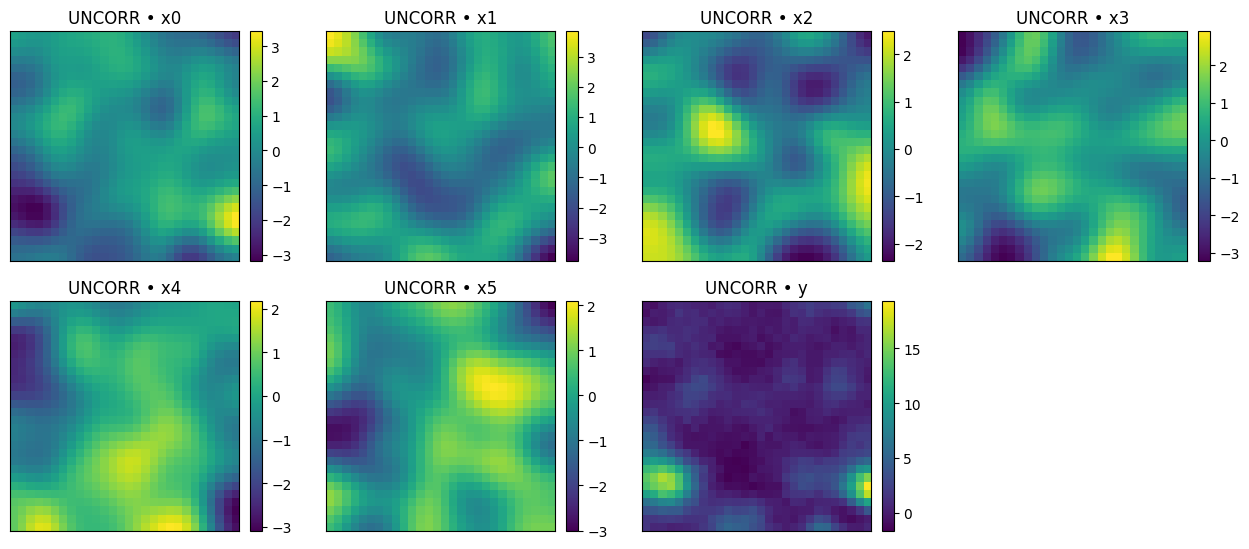

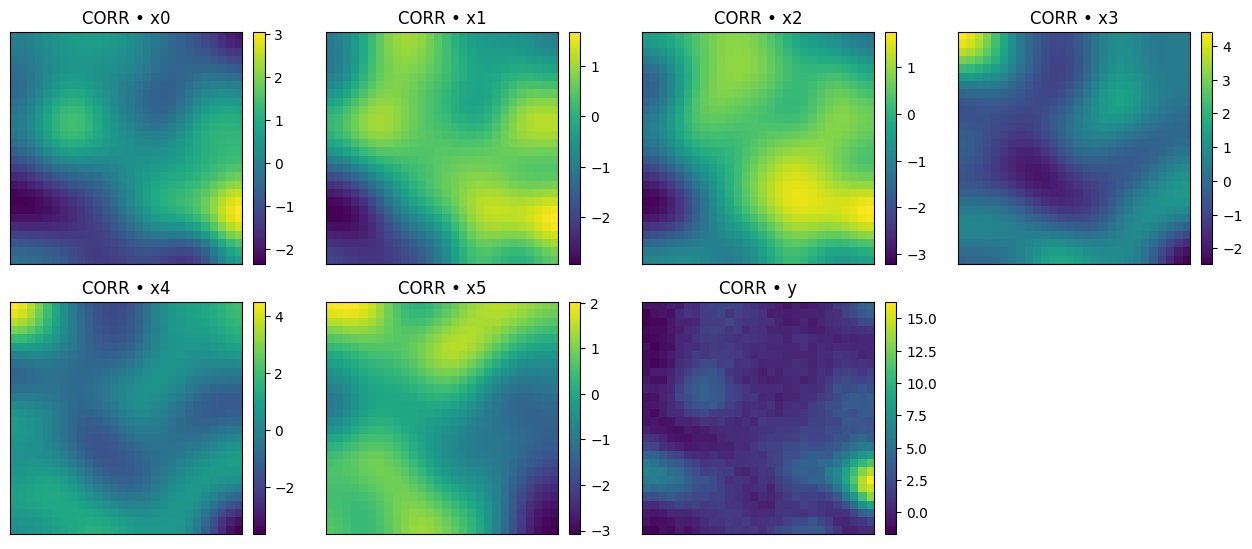

In [ ]:
# ==== Examples ====

# 1) Uncorrelated but spatially smooth (fills the box exactly: ny*nx samples)
df_s_unc, meta_unc, X_unc, y_unc = make_spatial_dataset(
    ny=28, nx=28, d=6,
    corr_mode="independent", rho=0.0, groups=None,
    spatial_sigma=2.5,            # increase for smoother/larger-scale trends
    target_kind="quad_sin",
    noise_sigma=0.25, seed=11
)
plot_maps(X_unc, y_unc, title_prefix="UNCORR • ")

# 2) Correlated groups with spatial trends
df_s_cor, meta_cor, X_cor, y_cor = make_spatial_dataset(
    ny=28, nx=28, d=6,
    corr_mode="groups", rho=0.85, groups=[[0,1,2],[3,4]],
    spatial_sigma=3.5,            # smoother maps
    target_kind="quad_sin",
    noise_sigma=0.25, seed=11
)
plot_maps(X_cor, y_cor, title_prefix="CORR • ")

,Title,n,d
0,UNCORR (spatial),784,7


,x0,x1,x2,x3,x4,x5,x
x0,1.00,-0.24,0.00,0.22,-0.12,0.26,0.44
x1,-0.24,1.00,-0.01,-0.31,-0.10,-0.15,-0.07
x2,0.00,-0.01,1.00,-0.15,-0.28,-0.09,-0.23
x3,0.22,-0.31,-0.15,1.00,0.07,-0.08,0.17
x4,-0.12,-0.10,-0.28,0.07,1.00,0.29,0.19
x5,0.26,-0.15,-0.09,-0.08,0.29,1.00,0.42
x,0.44,-0.07,-0.23,0.17,0.19,0.42,1.00


,feature,"pearson_r(y, xj)","spearman_rho(y, xj)"
2,x2,0.434,0.496
0,x0,-0.316,-0.168
1,x1,0.301,0.529
3,x3,-0.259,-0.192
4,x4,-0.195,-0.251
6,x,-0.117,-0.069
5,x5,-0.078,-0.101


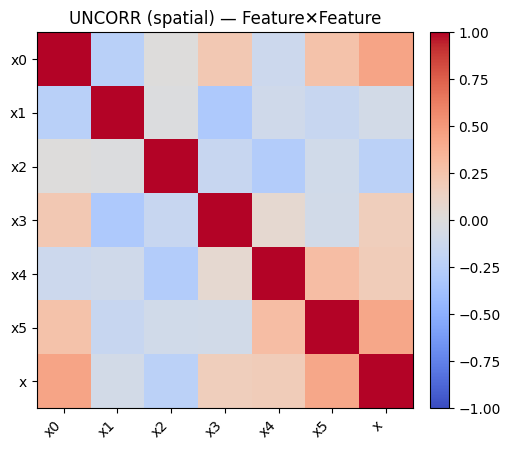

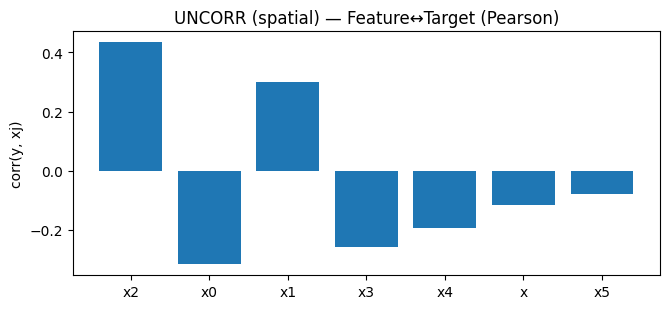

,Title,n,d
0,"CORR (spatial, groups ρ)",784,7


,x0,x1,x2,x3,x4,x5,x
x0,1.00,0.85,0.79,-0.11,-0.42,-0.60,0.40
x1,0.85,1.00,0.88,-0.22,-0.54,-0.54,0.53
x2,0.79,0.88,1.00,-0.08,-0.43,-0.43,0.63
x3,-0.11,-0.22,-0.08,1.00,0.81,0.21,0.12
x4,-0.42,-0.54,-0.43,0.81,1.00,0.40,-0.17
x5,-0.60,-0.54,-0.43,0.21,0.40,1.00,-0.54
x,0.40,0.53,0.63,0.12,-0.17,-0.54,1.00


,feature,"pearson_r(y, xj)","spearman_rho(y, xj)"
5,x5,-0.499,-0.409
0,x0,0.426,0.389
6,x,0.371,0.355
2,x2,0.253,0.417
1,x1,0.238,0.487
4,x4,-0.042,-0.121
3,x3,0.021,-0.062


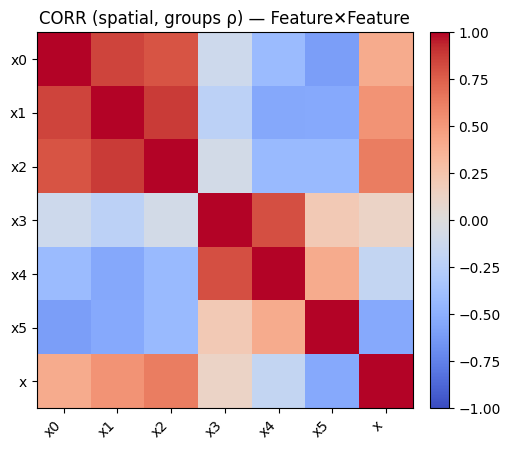

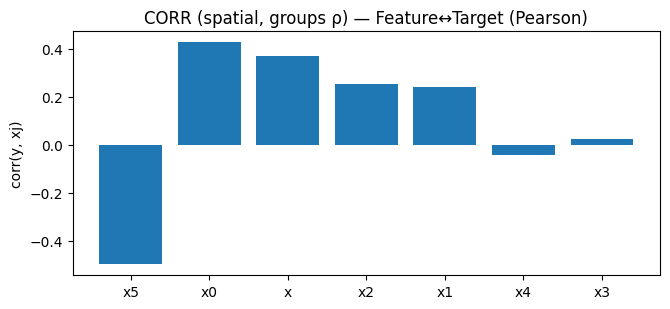

In [ ]:
# ==== CORRELATION TABLES + QUICK PLOTS ====
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def correlation_report(df, title="Correlation report", ycol="y"):
    xcols = [c for c in df.columns if c.startswith("x")]
    X = df[xcols]
    y = df[ycol]

    # --- Tables ---
    corr_ff = X.corr(method="pearson")               # feature-feature
    corr_fy = pd.DataFrame({
        "feature": xcols,
        "pearson_r(y, xj)": [np.corrcoef(X[c], y)[0,1] for c in xcols],
        "spearman_rho(y, xj)": [pd.Series(X[c]).corr(y, method="spearman") for c in xcols],
    }).sort_values("pearson_r(y, xj)", key=lambda s: s.abs(), ascending=False)

    # Pretty display
    display(pd.DataFrame({"Title":[title], "n":[len(df)], "d":[len(xcols)]}))
    try:
        display(corr_ff.style.format("{:.2f}").set_caption(f"{title} — Feature✕Feature (Pearson)"))
    except Exception:
        display(corr_ff)

    try:
        display(corr_fy.style.format({"pearson_r(y, xj)":"{:.3f}","spearman_rho(y, xj)":"{:.3f}"})
                .set_caption(f"{title} — Feature↔Target"))
    except Exception:
        display(corr_fy)

    # --- Heatmap + bar ---
    fig, ax = plt.subplots(1, 1, figsize=(5.2, 4.6))
    im = ax.imshow(corr_ff.to_numpy(), vmin=-1, vmax=1, cmap="coolwarm")
    ax.set_xticks(range(len(xcols))); ax.set_yticks(range(len(xcols)))
    ax.set_xticklabels(xcols, rotation=45, ha="right"); ax.set_yticklabels(xcols)
    ax.set_title(f"{title} — Feature✕Feature")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(6.8, 3.2))
    vals = corr_fy["pearson_r(y, xj)"].to_numpy()
    plt.bar(range(len(vals)), vals)
    plt.xticks(range(len(vals)), corr_fy["feature"], rotation=0)
    plt.ylabel("corr(y, xj)"); plt.title(f"{title} — Feature↔Target (Pearson)")
    plt.tight_layout(); plt.show()

    return {"corr_ff": corr_ff, "corr_fy": corr_fy}

# Run on your spatial datasets
rep_unc = correlation_report(df_s_unc, title="UNCORR (spatial)")
rep_cor = correlation_report(df_s_cor, title="CORR (spatial, groups ρ)")
